<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>
<hr/>
<font color="#800080" size=5>
Assignment 2 : Deep Autoregressive Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2025
<br>
</font>
<font face="Times New Roman" size=4>
</font>
<hr>
<font color='red'  size=4>
<br>
</font>
<font face="Times New Roman" size=4 align=center>
Feel free to ask your questions in Telegram : @ZahraSorkhei, @Ali99os
</font>
<br>
<hr>
</div></font>

**You should only change the blank sections, marked with TODO**

Pay attention to docstrings, as they may drastically help with your implementation.

You are advised to read all related papers and material, to help you better understand the design of each model.

# Question 1: Probabilistic Graph Forecasting with Autoregressive Decoders

This note gives a concise introduction to a temporal latent-variable model for **graph sequences** $\{G_t\}_{t=1}^T$ with $G_t=(X_t,A_t)$. It states the model, the training objective (ELBO) in a time-factorized form, the concrete likelihoods used for node features and edges, the effect of a deterministic decoder, and how to generate future graphs.



## Problem setup

We observe a sequence of graph snapshots

$$
G_t = (X_t, A_t), \quad t=1,\dots,T,
$$

where $X_t \in \mathbb{R}^{n \times d}$ stacks node feature vectors $x_t^v$ and $A_t \in \{0,1\}^{n \times n}$ is an undirected adjacency matrix (no self-loops). To capture temporal structure we introduce a latent trajectory

$$
Z_{1:T} = (Z_1, \dots, Z_T), \quad Z_t \in \mathbb{R}^m,
$$

where $Z_t$ is a global latent representation of the whole graph at time $t$.


## Generative (autoregressive latent) model

An autoregressive factorization is used:

$$
p_\theta(X_{1:T}, A_{1:T}, Z_{1:T})
= p(Z_1) \prod_{t=1}^{T-1} p_\theta(Z_{t+1}\mid Z_t)\; p_\theta(X_{t+1}, A_{t+1}\mid Z_t)
$$

Intuition: the latent $Z_t$ summarizes the state at $t$; a transition model $p_\theta(Z_{t+1}\mid Z_t)$ evolves it; conditioned on the current latent we predict the *next* snapshot $(X_{t+1}, A_{t+1})$.

We approximate the true posterior with an amortized encoder (e.g. a GNN+RNN):

$$
q_\phi(Z_t \mid X_{1:t}, A_{1:t}) \quad \text{(often factorized across $t$ for amortization).}
$$


## Variational lower bound (ELBO) — time decomposition

Using the variational approximation

$$
q_\phi(Z_{1:T}\mid X_{1:T},A_{1:T}) = \prod_{t=1}^T q_\phi(Z_t \mid X_{1:t},A_{1:t}),
$$

the marginal log-likelihood admits the ELBO:

$$
\log p_\theta(X_{1:T}, A_{1:T}) \ge
\mathbb{E}_{q_\phi} \Big[ \sum_{t=1}^{T-1} \log p_\theta(X_{t+1}, A_{t+1} \mid Z_t) \Big]
- \mathrm{KL}\big(q_\phi(Z_1 \mid X_1, A_1) \,\|\, p(Z_1)\big)
- \sum_{t=1}^{T-1} \mathbb{E}_{q_\phi} \Big[ \mathrm{KL}\big(q_\phi(Z_{t+1}\mid X_{1:t+1}, A_{1:t+1}) \,\|\, p_\theta(Z_{t+1}\mid Z_t)\big) \Big].
$$

Thus the objective is a sum over time: per-step reconstruction terms plus per-step KL penalties that align the encoder's posterior with the learned transition prior.



## Explicit reconstruction likelihoods

If the decoder factorizes into Gaussian node-features and Bernoulli edges:

- **Node features (per node $v$)**

$$
p_\theta(x_{t+1}^v \mid Z_t) = \mathcal{N}(x_{t+1}^v \mid \mu_\theta^v(Z_t), \Sigma_\theta^v(Z_t)),
$$

hence the feature log-likelihood (for all nodes) is

$$
\log p_\theta(X_{t+1} \mid Z_t)
= -\frac{1}{2} \sum_{v=1}^n \Big[ (x_{t+1}^v - \mu_\theta^v)^\top (\Sigma_\theta^v)^{-1} (x_{t+1}^v - \mu_\theta^v) + \log \det(2 \pi \Sigma_\theta^v) \Big].
$$

(In practice $\Sigma^v$ is taken diagonal or shared for numerical stability.)

- **Edges (for unordered pairs $u<v$)**

$$
p_\theta(A_{t+1} \mid Z_t) = \prod_{u<v} \mathrm{Bernoulli}\big(A_{t+1}^{uv} \mid \pi_\theta^{uv}(Z_t)\big),
$$

so

$$
\log p_\theta(A_{t+1} \mid Z_t) = \sum_{u<v} \Big[ A_{uv} \log \pi_{uv} + (1-A_{uv}) \log (1-\pi_{uv}) \Big].
$$

Combine them:

$$
\log p_\theta(X_{t+1}, A_{t+1} \mid Z_t) = \log p_\theta(X_{t+1} \mid Z_t) + \log p_\theta(A_{t+1} \mid Z_t).
$$


## Deterministic decoder

If the decoder is deterministic (e.g. $X_{t+1}=f_\theta(Z_t)$, $A_{t+1}=g_\theta(Z_t)$ or equivalently Gaussian with vanishing variance), then:

- The likelihood becomes a Dirac (or degenerate Gaussian); log-likelihood is $-\infty$ off the model manifold — numerically unstable.
- Deterministic decoders cannot model multimodality: a single $Z_t$ maps to a single snapshot, so they fail when the conditional distribution is multi-valued.
- Training tends to overfit (model memorizes) or produce poor uncertainty calibration. Probabilistic decoders (non-zero variance, Bernoulli edges) are preferred for stable likelihood-based training and to capture uncertainty/diversity.


## Generating future graphs

Given observed history $X_{1:T}, A_{1:T}$:

1. Infer the posterior at final time: $q_\phi(Z_T \mid X_{1:T}, A_{1:T})$ and sample $z_T \sim q_\phi$ (or use the posterior mean).
2. For $h=1$ to $H$:
   - Sample latent: $z_{T+h} \sim p_\theta(Z_{T+h} \mid z_{T+h-1})$.
   - Sample (or take mean of) snapshot: $(\tilde X_{T+h}, \tilde A_{T+h}) \sim p_\theta(\cdot \mid z_{T+h-1})$ (or use the decoder mean).





In [1]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score

## 1) Synthetic dynamic graph dataset
**Goal:**  
Create dynamic graphs using SBM with Gaussian node features.

**Hints:**  
- `generate_sbm`: adjacency with `p_in` (intra) and `p_out` (inter) edges.  
- `generate_features`: node features from `N(μ_k, Σ_k)` per community.  
- `generate_sequence`: simulate T timesteps with drift and edge flips.  
- `_getitem_` / `_len_`: return sequences.  
- `collate_fn`: batch multiple sequences.

**Output:**  
- `X_seq`: `[T, n_nodes, feat_dim]`  
- `A_seq`: `[T, n_nodes, n_nodes]`

In [2]:
class SyntheticGraphDataset(Dataset):
    """
    Generate synthetic evolving graphs.
    - Each sequence has T snapshots.
    - Node features: random walk.
    - Edges: flip with small probability.
    """
    def __init__(self, n_nodes=30, feat_dim=4, T=40, n_seq=200, p_flip=0.03):
        """
        Args:
            n_nodes (int): Number of nodes in the graph.
            feat_dim (int): Dimensionality of the node features.
            T (int): Number of time steps (snapshots) in each sequence.
            n_seq (int): Number of sequences (graphs) to generate.
            p_flip (float): Probability of edge flip between two consecutive snapshots.
        """
        self.n_nodes = n_nodes
        self.feat_dim = feat_dim
        self.T = T
        self.n_seq = n_seq
        self.p_flip = p_flip
        self.sequences = [self.generate_sequence() for _ in range(n_seq)]

    def generate_sequence(self):
        """
        Generate a sequence of graphs with random walk node features and edge flips.
        """
        X_seq = np.zeros((self.T, self.n_nodes, self.feat_dim))
        A_seq = np.zeros((self.T, self.n_nodes, self.n_nodes))

        # Initial adjacency matrix (using SBM or random)
        A_seq[0] = np.random.randint(0, 2, (self.n_nodes, self.n_nodes))
        np.fill_diagonal(A_seq[0], 0)  # No self-loops

        # Generate node features with random walk (Gaussian noise)
        X_seq[0] = np.random.randn(self.n_nodes, self.feat_dim)

        for t in range(1, self.T):
            # Random walk: add Gaussian noise to node features
            X_seq[t] = X_seq[t-1] + np.random.randn(self.n_nodes, self.feat_dim)

            # Edge flip with probability p_flip
            A_seq[t] = A_seq[t-1].copy()
            flip_mask = np.random.rand(self.n_nodes, self.n_nodes) < self.p_flip
            A_seq[t] = np.logical_xor(A_seq[t], flip_mask)
            np.fill_diagonal(A_seq[t], 0)  # Ensure no self-loops

        return torch.tensor(X_seq, dtype=torch.float32), torch.tensor(A_seq, dtype=torch.float32)

    def __len__(self):
        """
        Return the number of sequences in the dataset.
        """
        return self.n_seq

    def __getitem__(self, idx):
        """
        Retrieve the sequence at index idx.
        """
        return self.sequences[idx]

def collate_fn(batch):
    """
    Collate function to batch multiple sequences.
    """
    X_batch = torch.stack([x for x, _ in batch], dim=0)
    A_batch = torch.stack([a for _, a in batch], dim=0)
    return X_batch, A_batch


## 2) Encoder, Prior, Decoder

### SimpleGraphEncoder
Aggregates node features and degree statistics.  
Computes graph-level latent embeddings `mu` and `logvar` for VAE.  
No external graph libraries required; uses only PyTorch.

### TransitionPrior
Models the latent temporal evolution `p(Z_{t+1} | Z_t)` as a Gaussian.  
Produces mean and variance for autoregressive sampling in VAE.

### Decoder
Reconstructs node features and adjacency matrices from latent `Z_t`.  
Uses node embeddings combined with latent vectors for feature decoding.  
Produces edge logits for Bernoulli reconstruction of adjacency.  
Supports probabilistic reconstruction via Gaussian features + Bernoulli edges.

In [3]:
import torch
import torch.nn as nn

class SimpleGraphEncoder(nn.Module):
    """
    Enhanced encoder with more FC layers for better feature extraction.
    """
    def __init__(self, feat_dim, hidden_dim, latent_dim, dropout_rate=0.2):
        """
        Args:
            feat_dim (int): Dimensionality of node features.
            hidden_dim (int): Dimensionality of hidden layers.
            latent_dim (int): Dimensionality of the latent space.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(SimpleGraphEncoder, self).__init__()
        self.feat_dim = feat_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Expanded MLP with more layers for processing node features
        self.fc1 = nn.Linear(feat_dim, hidden_dim * 2)
        self.bn1 = nn.BatchNorm1d(hidden_dim * 2)
        
        self.fc2 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2)
        
        # Additional residual layer
        self.fc_res = nn.Linear(hidden_dim * 2, hidden_dim // 2) if hidden_dim * 2 != hidden_dim // 2 else None
        
        # MLP to compute mu and logvar for VAE
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim // 2, latent_dim)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, X, A):
        """
        Forward pass through the encoder.
        
        Args:
            X (Tensor): Node feature matrix of shape (batch_size, n_nodes, feat_dim).
            A (Tensor): Adjacency matrix of shape (batch_size, n_nodes, n_nodes).
            
        Returns:
            mu (Tensor): Latent mean vector of shape (batch_size, latent_dim).
            logvar (Tensor): Latent log variance vector of shape (batch_size, latent_dim).
        """
        batch_size = X.size(0)
        
        # Aggregate node features by averaging over the nodes for each batch
        node_features = torch.mean(X, dim=1)  # Shape: (batch_size, feat_dim)
        
        # Pass node features through enhanced MLP with residual connections
        h1 = self.leaky_relu(self.bn1(self.fc1(node_features)))
        h1 = self.dropout(h1)
        
        h2 = self.leaky_relu(self.bn2(self.fc2(h1)))
        h2 = self.dropout(h2)
        
        h3 = self.leaky_relu(self.bn3(self.fc3(h2)))
        
        # Optional residual connection
        if self.fc_res is not None and h1.shape[1] != h3.shape[1]:
            h1_res = self.fc_res(h1)
            h3 = h3 + h1_res  # Residual connection
        
        h3 = self.dropout(h3)
        
        # Compute mean and log variance for VAE latent variables
        mu = self.fc_mu(h3)
        logvar = self.fc_logvar(h3)
        
        return mu, logvar


class TransitionPrior(nn.Module):
    """ p(Z_{t+1}|Z_t) Gaussian with more expressive modeling """
    def __init__(self, latent_dim, hidden_dim=64):
        """
        Args:
            latent_dim (int): Dimensionality of the latent space.
            hidden_dim (int): Hidden dimension for transition modeling.
        """
        super(TransitionPrior, self).__init__()
        self.latent_dim = latent_dim
        
        # More expressive transition model with hidden layers
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.dropout = nn.Dropout(0.1)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, z_t):
        """
        Forward pass to compute the transition prior from Z_t to Z_{t+1}.
        
        Args:
            z_t (Tensor): Latent vector at time t of shape (batch_size, latent_dim).
            
        Returns:
            mean (Tensor): Mean of the Gaussian prior at time t+1.
            logvar (Tensor): Log variance of the Gaussian prior at time t+1.
        """
        h = self.leaky_relu(self.fc1(z_t))
        h = self.dropout(h)
        h = self.leaky_relu(self.fc2(h))
        
        mean = self.fc_mean(h)
        logvar = self.fc_logvar(h)
        
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, feat_dim, latent_dim, n_nodes, dropout_rate=0.2):
        super(Decoder, self).__init__()
        self.feat_dim = feat_dim
        self.latent_dim = latent_dim
        self.n_nodes = n_nodes
        
        # Enhanced MLP for decoding node features with more layers
        self.fc1 = nn.Linear(latent_dim, latent_dim * 4)
        self.bn1 = nn.BatchNorm1d(latent_dim * 4)
        
        self.fc2 = nn.Linear(latent_dim * 4, latent_dim * 2)
        self.bn2 = nn.BatchNorm1d(latent_dim * 2)
        
        self.fc3 = nn.Linear(latent_dim * 2, latent_dim)
        self.bn3 = nn.BatchNorm1d(latent_dim)
        
        self.fc4 = nn.Linear(latent_dim, n_nodes * feat_dim)
        
        # Enhanced edge decoder with more layers
        self.edge_fc1 = nn.Linear(latent_dim, latent_dim * 2)
        self.edge_bn1 = nn.BatchNorm1d(latent_dim * 2)
        
        self.edge_fc2 = nn.Linear(latent_dim * 2, latent_dim)
        self.edge_bn2 = nn.BatchNorm1d(latent_dim)
        
        self.edge_fc3 = nn.Linear(latent_dim, n_nodes * (n_nodes - 1) // 2)
        
        self.dropout = nn.Dropout(dropout_rate)
        self.leaky_relu = nn.LeakyReLU(0.1)

    def forward(self, z_t):
        batch_size = z_t.size(0)
        
        # Node features with enhanced network
        h = self.leaky_relu(self.bn1(self.fc1(z_t)))
        h = self.dropout(h)
        
        h = self.leaky_relu(self.bn2(self.fc2(h)))
        h = self.dropout(h)
        
        h = self.leaky_relu(self.bn3(self.fc3(h)))
        h = self.dropout(h)
        
        X_t = self.fc4(h)
        X_t = X_t.view(batch_size, self.n_nodes, self.feat_dim)
        
        # Edges with enhanced network
        h_edge = self.leaky_relu(self.edge_bn1(self.edge_fc1(z_t)))
        h_edge = self.dropout(h_edge)
        
        h_edge = self.leaky_relu(self.edge_bn2(self.edge_fc2(h_edge)))
        h_edge = self.dropout(h_edge)
        
        edge_logits = self.edge_fc3(h_edge)
        
        # Create adjacency matrix
        A_t_logits = torch.zeros(batch_size, self.n_nodes, self.n_nodes).to(z_t.device)
        triu_indices = torch.triu_indices(self.n_nodes, self.n_nodes, offset=1)
        A_t_logits[:, triu_indices[0], triu_indices[1]] = edge_logits
        
        return X_t, A_t_logits

`reparameterize`: samples latent variable using the reparameterization trick.  
`kl_gauss`: closed-form KL divergence between two Gaussians.  
`nll_gaussian`: negative log-likelihood for node features.  
`nll_bernoulli`: negative log-likelihood (binary cross-entropy) for edges.

In [4]:
def reparameterize(mu, logvar):
    """
    Sample from a Gaussian distribution using the reparameterization trick.
    
    Args:
        mu (Tensor): Mean of the Gaussian distribution.
        logvar (Tensor): Log variance of the Gaussian distribution.
        
    Returns:
        z (Tensor): Sampled latent variable.
    """
    std = torch.exp(0.5 * logvar)  # Standard deviation from log variance
    eps = torch.randn_like(std)  # Standard normal noise
    z = mu + eps * std  # Reparameterization trick: z = mu + std * eps
    return z
    
def kl_gauss(mu_q, logvar_q, mu_p, logvar_p, free_bits=0.1):
    """
    Compute KL with free bits to prevent posterior collapse.
    """
    var_q = torch.exp(logvar_q)
    var_p = torch.exp(logvar_p)
    
    var_q = torch.clamp(var_q, min=1e-6)
    var_p = torch.clamp(var_p, min=1e-6)
    
    kl = 0.5 * (torch.log(var_p) - torch.log(var_q) + 
                (var_q + (mu_q - mu_p)**2) / var_p - 1)
    
    # Free bits: ensure KL is at least free_bits per dimension
    kl = torch.sum(kl, dim=1)  # Sum over latent dimensions
    kl = torch.mean(torch.max(kl, free_bits * kl.new_ones(kl.shape)))
    
    return kl
    
def nll_gaussian(x, mu, logvar=None):
    """
    Compute the negative log-likelihood for a Gaussian distribution.
    """
    if logvar is None:
        # Use fixed variance if not provided
        logvar = torch.zeros_like(mu)
    
    var = torch.exp(logvar)
    var = torch.clamp(var, min=1e-6)  # Numerical stability
    
    # More stable calculation
    nll = 0.5 * torch.sum(
        torch.log(2 * torch.pi * var) + (x - mu)**2 / var, 
        dim=[1, 2]  # Sum over nodes and features
    )
    return torch.mean(nll)
    
def nll_bernoulli(logits, target):
    """
    Compute the negative log-likelihood for a Bernoulli distribution (binary cross-entropy).
    
    Args:
        logits (Tensor): Logits for the Bernoulli distribution, typically output from the decoder.
        target (Tensor): Ground truth adjacency matrix, binary (0 or 1) indicating edge presence.
        
    Returns:
        nll (Tensor): Negative log-likelihood of the adjacency matrix.
    """
    # Binary cross-entropy for Bernoulli distribution
    nll = torch.sum(torch.nn.functional.binary_cross_entropy_with_logits(logits, target, reduction='none'))
    return nll


## 4) TemporalGraphVAE
Define the Temporal Graph VAE model.  
- Encode node features & adjacency into latent `z`.  
- Model transitions `p(z_{t+1}|z_t)`.  
- Decode `z` to reconstruct node features and edges.  
- Compute ELBO (reconstruction + KL) for training.

In [5]:
class TemporalGraphVAE(nn.Module):
    def __init__(self, n_nodes, feat_dim, z_dim=16):
        """
        Temporal Graph Variational Autoencoder (VAE) for modeling graph sequences.
        
        Args:
            n_nodes (int): Number of nodes in the graph.
            feat_dim (int): Dimensionality of the node features.
            z_dim (int): Dimensionality of the latent space.
        """
        super(TemporalGraphVAE, self).__init__()
        
        self.n_nodes = n_nodes
        self.feat_dim = feat_dim
        self.z_dim = z_dim

        # Encoder: Encodes node features and adjacency matrix to latent variables
        self.encoder = SimpleGraphEncoder(feat_dim, hidden_dim=64, latent_dim=z_dim)

        # Transition Prior: Models the latent temporal evolution
        self.transition_prior = TransitionPrior(latent_dim=z_dim)

        # Decoder: Decodes latent variables to reconstruct node features and edges
        self.decoder = Decoder(self.feat_dim, latent_dim=self.z_dim, n_nodes=self.n_nodes)

    def forward(self, X_seq, A_seq, kl_weight=1.0):
        """
        Forward pass through the Temporal Graph VAE.
        
        Args:
            X_seq (Tensor): Node feature sequence of shape (T, n_nodes, feat_dim).
            A_seq (Tensor): Adjacency matrix sequence of shape (T, n_nodes, n_nodes).
            kl_weight (float): Weight for the KL divergence term in the ELBO.
            
        Returns:
            elbo (Tensor): The computed ELBO for the given sequence.
            recon_loss (Tensor): The reconstruction loss.
            kl_loss (Tensor): The KL divergence loss.
        """
        T = X_seq.size(0)  # Number of timesteps
        
        # Initialize losses
        recon_loss = 0.0
        kl_loss = 0.0
        
        # Initialize latent variable for t=1 using the encoder
        mu_1, logvar_1 = self.encoder(X_seq[0], A_seq[0])
        z_t = reparameterize(mu_1, logvar_1)
        
        # For each timestep t, calculate the reconstruction and KL loss
        for t in range(1, T):
            # Decoder reconstructs node features and edges
            X_t, A_t_logits = self.decoder(z_t)
            
            # Reconstruction loss for node features (NLL for Gaussian)
            recon_loss += torch.mean(nll_gaussian(X_seq[t], X_t, logvar=torch.zeros_like(X_t)))
            
            # Reconstruction loss for edges (NLL for Bernoulli)
            recon_loss += torch.mean(nll_bernoulli(A_t_logits, A_seq[t]))

            # Transition prior: Model latent evolution p(z_{t+1} | z_t)
            mu_prior, logvar_prior = self.transition_prior(z_t)
            kl_loss += kl_gauss(mu_q=mu_1, logvar_q=logvar_1, mu_p=mu_prior, logvar_p=logvar_prior)

            # Reparameterize latent variable at time t+1
            mu_t, logvar_t = self.encoder(X_seq[t], A_seq[t])
            z_t = reparameterize(mu_t, logvar_t)
        
        # Compute ELBO (Reconstruction loss + KL divergence)
        elbo = recon_loss + kl_weight * kl_loss
        return elbo, recon_loss, kl_loss


## 5) Visualization helpers

In [6]:
def visualize_graphs(A_true, A_recon_probs, communities, epoch, K, p_in, p_out):
    A_recon_bin = (A_recon_probs >= 0.5).astype(int)
    G_true, G_recon = nx.from_numpy_array(A_true), nx.from_numpy_array(A_recon_bin)
    pos = nx.spring_layout(G_true, seed=42)
    plt.figure(figsize=(9, 4))
    plt.suptitle(f"SBM Graphs (Epoch {epoch})\n"
                 f"K={K}, Intra={p_in}, Inter={p_out}\n"
                 f"In each component: X~N(μ_k, Σ_k)", fontsize=10)
    plt.subplot(1, 2, 1)
    nx.draw(G_true, pos, node_color=communities, cmap='tab10', node_size=100, with_labels=False, alpha=0.8)
    plt.title("True graph")
    plt.subplot(1, 2, 2)
    nx.draw(G_recon, pos, node_color=communities, cmap='tab10', node_size=100, with_labels=False, alpha=0.8)
    plt.title("Reconstructed (p≥0.5)")
    plt.tight_layout()
    plt.show()


## 6) Training
Train the Temporal Graph VAE.  
- Loop over epochs and batches.  
- Forward pass, compute loss, backprop, optimizer step.  
- Track and print losses (`Total`, `Recon`, `KL`).  
- Optionally visualize true vs reconstructed graphs every `vis_interval`.

In [7]:
import torch
import matplotlib.pyplot as plt
import networkx as nx

def train_model(model, train_loader, optimizer, vis_interval=5, epochs=30, kl_weight=1.0):
    """
    Train the Temporal Graph VAE model.

    Args:
        model (nn.Module): The TemporalGraphVAE model.
        train_loader (DataLoader): DataLoader for the training data.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        vis_interval (int): How often to visualize the true vs reconstructed graphs (in epochs).
        epochs (int): Number of epochs to train the model.
        kl_weight (float): Weight for the KL divergence term in the ELBO.
    """
    # Set the model to training mode
    model.train()

    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        recon_loss = 0.0
        kl_loss = 0.0

        # Loop over batches
        for X_seq, A_seq in train_loader:
            optimizer.zero_grad()

            # Move data to the correct device (if using GPU)
            X_seq = X_seq.to(model.device)
            A_seq = A_seq.to(model.device)

            # Forward pass through the model
            elbo, recon, kl = model(X_seq, A_seq, kl_weight=kl_weight)

            # Compute total loss
            loss = elbo

            # Backpropagation
            loss.backward()

            # Optimizer step
            optimizer.step()

            # Accumulate losses
            total_loss += loss.item()
            recon_loss += recon.item()
            kl_loss += kl.item()

        # Print loss for the current epoch
        print(f"Epoch [{epoch}/{epochs}] - "
              f"Total Loss: {total_loss:.4f}, "
              f"Recon Loss: {recon_loss:.4f}, "
              f"KL Loss: {kl_loss:.4f}")

        # Optionally visualize the graphs every `vis_interval` epochs
        if epoch % vis_interval == 0:
            # Visualize the last batch
            X_seq_batch, A_seq_batch = next(iter(train_loader))  # Get one batch for visualization
            X_seq_batch = X_seq_batch.to(model.device)
            A_seq_batch = A_seq_batch.to(model.device)
            
            # Use the model to generate reconstructed graphs
            with torch.no_grad():
                # FIX: encoder returns only 2 values (mu, logvar), not 3
                mu, logvar = model.encoder(X_seq_batch[:, 0], A_seq_batch[:, 0])  # Encode first snapshot
                z_t = reparameterize(mu, logvar)  # Sample from the distribution
                _, A_recon_logits = model.decoder(z_t)  # Get edge logits
                A_recon_probs = torch.sigmoid(A_recon_logits)  # Apply sigmoid to get probabilities
                
            # Convert to numpy arrays for visualization
            A_true = A_seq_batch[0, 0].cpu().numpy()  # First batch, first timestep
            A_recon_probs = A_recon_probs[0].cpu().numpy()  # First batch reconstruction
            
            # Use a simple community assignment for visualization (all nodes in same community)
            communities = np.zeros(A_true.shape[0])
            
            # Visualize the graphs
            visualize_graphs(A_true, A_recon_probs, communities, epoch, K=1, p_in=0.8, p_out=0.2)

## 7) Testing
Evaluate the trained model on sample sequences.  
- Encode last snapshot, decode to get reconstructed adjacency/features.  
- Compute simple metrics (e.g., edge accuracy).  
- Visualize true vs reconstructed graphs for verification.

In [8]:
def test_model(model, dataset):
    """
    Evaluate the trained TemporalGraphVAE model on sample sequences.

    Args:
        model (nn.Module): The trained TemporalGraphVAE model.
        dataset (Dataset): The test dataset, should return sequences of (X_seq, A_seq).
    """
    model.eval()  # Set the model to evaluation mode

    edge_accuracies = []  # List to store edge accuracy for each sample
    plotted = False  # Flag to ensure we plot only one graph

    with torch.no_grad():  # No need to track gradients during testing
        for X_seq, A_seq in dataset:  # Iterate through the test dataset
            # Move data to the appropriate device (if using GPU)
            X_seq = X_seq.to(model.device)
            A_seq = A_seq.to(model.device)
            
            # Ensure we have batch dimension
            if X_seq.dim() == 3:  # (T, n_nodes, feat_dim) - add batch dimension
                X_seq = X_seq.unsqueeze(0)  # (1, T, n_nodes, feat_dim)
                A_seq = A_seq.unsqueeze(0)  # (1, T, n_nodes, n_nodes)

            # Encode the last snapshot and sample the latent variables
            mu_last, logvar_last = model.encoder(X_seq[:, -1], A_seq[:, -1])  # Use batch indexing
            z_last = reparameterize(mu_last, logvar_last)

            # Decode the latent variable to reconstruct the last adjacency matrix and node features
            X_recon, A_recon_logits = model.decoder(z_last)
            A_recon_probs = torch.sigmoid(A_recon_logits)  # Get edge probabilities
            
            # Convert reconstructed adjacency probabilities to binary values
            A_recon_bin = (A_recon_probs >= 0.5).float()  # Apply threshold to get binary matrix

            # Compute edge accuracy (binary accuracy for edges)
            # Use only the first batch element for accuracy calculation
            A_true_flat = A_seq[0, -1].view(-1).cpu().numpy()  # Flatten the true adjacency matrix
            A_recon_flat = A_recon_bin[0].view(-1).cpu().numpy()  # Flatten the reconstructed adjacency matrix
            edge_accuracy = accuracy_score(A_true_flat, A_recon_flat)
            edge_accuracies.append(edge_accuracy)

            # Plot only one graph (the first one we encounter)
            if not plotted:
                A_true = A_seq[0, -1].cpu().numpy()
                A_recon_probs_np = A_recon_probs[0].cpu().numpy()
                communities = np.zeros(A_true.shape[0])  # Simple placeholder

                # Visualize the graphs
                visualize_graphs(A_true, A_recon_probs_np, communities, epoch='Test', K=1, p_in=0.8, p_out=0.2)
                plotted = True  # Set flag to True so we don't plot again

    # Compute average edge accuracy across the test set
    avg_edge_accuracy = np.mean(edge_accuracies)
    print(f"Average Edge Accuracy: {avg_edge_accuracy:.4f}")

## 8) Train and Test

**The final result can be much better than the displayed result.**

Training the model...
Epoch [1/100] - Total Loss: 5178519.4219, Recon Loss: 5171980.2500, KL Loss: 653.9111
Epoch [2/100] - Total Loss: 5163825.9688, Recon Loss: 5159676.9531, KL Loss: 414.9033
Epoch [3/100] - Total Loss: 5150592.2031, Recon Loss: 5147056.9219, KL Loss: 353.5252
Epoch [4/100] - Total Loss: 5141152.2344, Recon Loss: 5137823.1562, KL Loss: 332.9014
Epoch [5/100] - Total Loss: 5130999.7500, Recon Loss: 5127996.1875, KL Loss: 300.3528


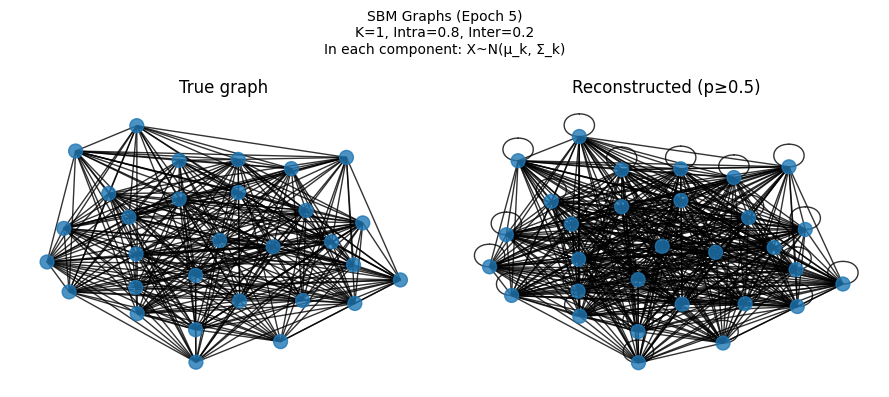

Epoch [6/100] - Total Loss: 5123663.6406, Recon Loss: 5120467.2344, KL Loss: 319.6394
Epoch [7/100] - Total Loss: 5116813.9844, Recon Loss: 5113047.1094, KL Loss: 376.6902
Epoch [8/100] - Total Loss: 5109551.9062, Recon Loss: 5105391.4062, KL Loss: 416.0467
Epoch [9/100] - Total Loss: 5103493.1406, Recon Loss: 5098830.7656, KL Loss: 466.2421
Epoch [10/100] - Total Loss: 5097985.9531, Recon Loss: 5092885.7500, KL Loss: 510.0212


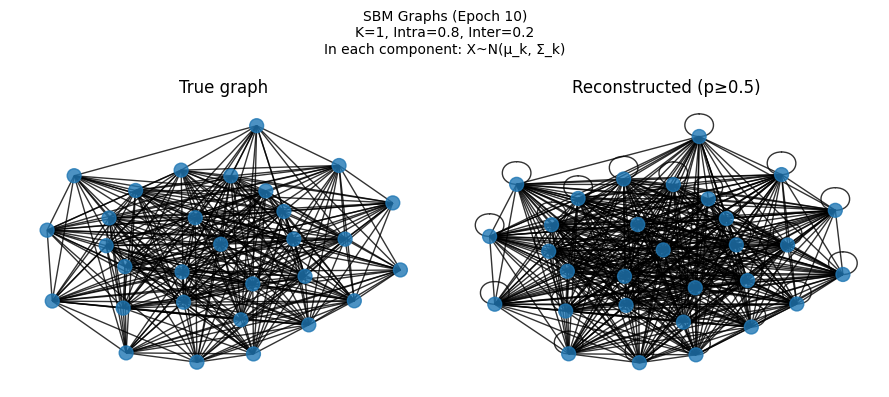

Epoch [11/100] - Total Loss: 5093367.2812, Recon Loss: 5088620.7031, KL Loss: 474.6507
Epoch [12/100] - Total Loss: 5090776.2344, Recon Loss: 5085530.1250, KL Loss: 524.6069
Epoch [13/100] - Total Loss: 5087492.9219, Recon Loss: 5083023.8750, KL Loss: 446.9058
Epoch [14/100] - Total Loss: 5088293.0781, Recon Loss: 5083231.4219, KL Loss: 506.1700
Epoch [15/100] - Total Loss: 5084942.0469, Recon Loss: 5080554.6875, KL Loss: 438.7383


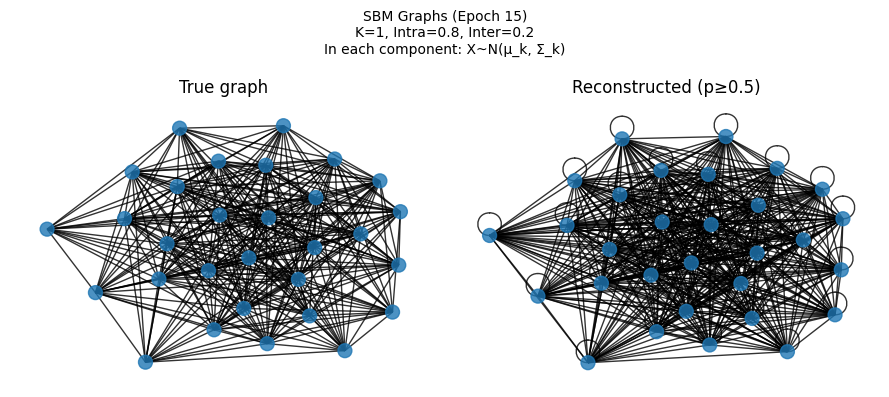

Epoch [16/100] - Total Loss: 5083718.9219, Recon Loss: 5079505.6406, KL Loss: 421.3230
Epoch [17/100] - Total Loss: 5082612.7188, Recon Loss: 5078932.0000, KL Loss: 368.0704
Epoch [18/100] - Total Loss: 5082097.4844, Recon Loss: 5078864.7969, KL Loss: 323.2772
Epoch [19/100] - Total Loss: 5081273.2969, Recon Loss: 5077513.6562, KL Loss: 375.9625
Epoch [20/100] - Total Loss: 5080477.7656, Recon Loss: 5077339.3438, KL Loss: 313.8385


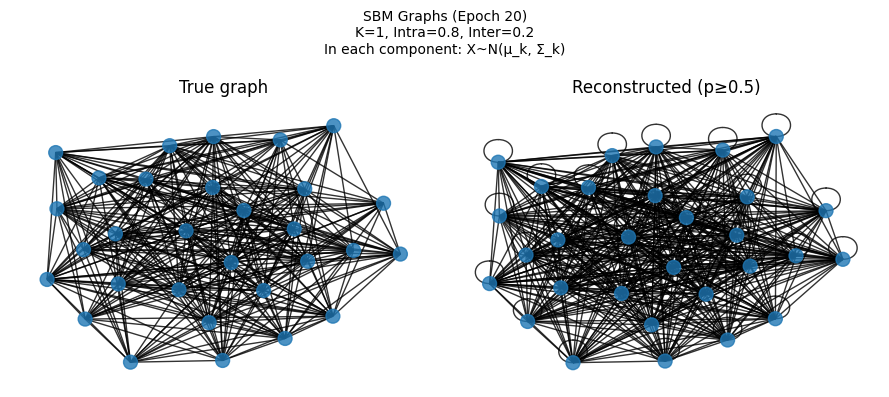

Epoch [21/100] - Total Loss: 5080556.4062, Recon Loss: 5077448.0781, KL Loss: 310.8377
Epoch [22/100] - Total Loss: 5080043.2188, Recon Loss: 5077230.6094, KL Loss: 281.2592
Epoch [23/100] - Total Loss: 5079692.3906, Recon Loss: 5076792.4531, KL Loss: 290.0006
Epoch [24/100] - Total Loss: 5079071.9375, Recon Loss: 5076327.2500, KL Loss: 274.4717
Epoch [25/100] - Total Loss: 5079236.3281, Recon Loss: 5076558.2188, KL Loss: 267.8020


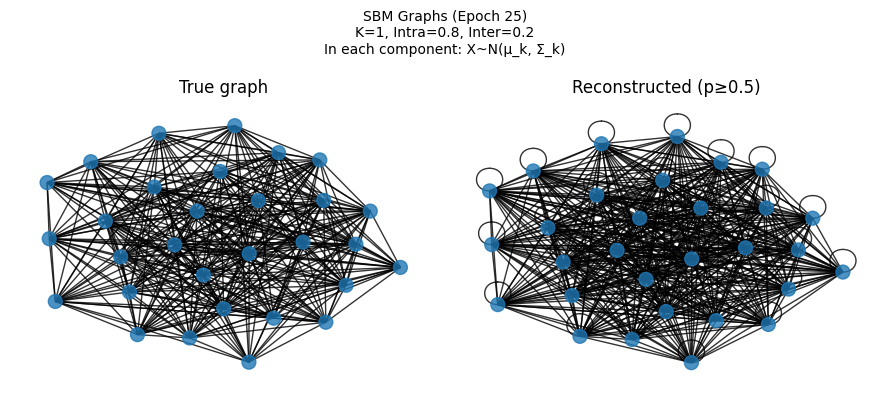

Epoch [26/100] - Total Loss: 5078902.6719, Recon Loss: 5076262.0156, KL Loss: 264.0553
Epoch [27/100] - Total Loss: 5078419.2188, Recon Loss: 5075710.3281, KL Loss: 270.8875
Epoch [28/100] - Total Loss: 5078090.5625, Recon Loss: 5075285.5312, KL Loss: 280.5029
Epoch [29/100] - Total Loss: 5077982.5938, Recon Loss: 5075678.2812, KL Loss: 230.4376
Epoch [30/100] - Total Loss: 5077344.2656, Recon Loss: 5075083.5000, KL Loss: 226.0809


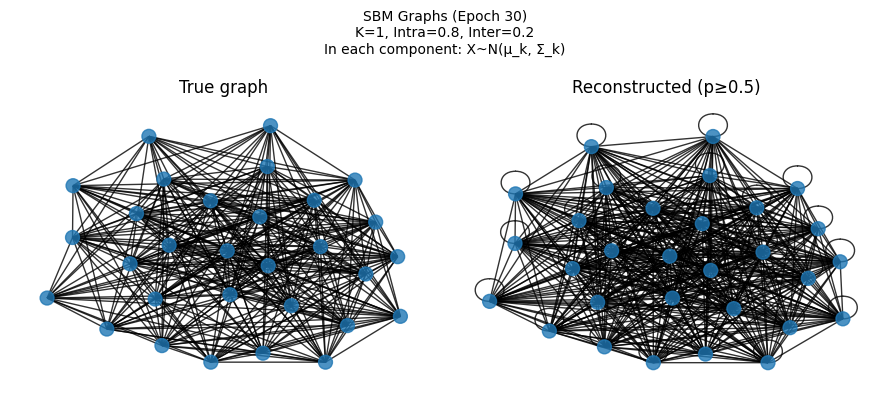

Epoch [31/100] - Total Loss: 5076692.7031, Recon Loss: 5074326.9531, KL Loss: 236.5767
Epoch [32/100] - Total Loss: 5076648.5312, Recon Loss: 5074560.1094, KL Loss: 208.8386
Epoch [33/100] - Total Loss: 5076829.4844, Recon Loss: 5074580.1250, KL Loss: 224.9273
Epoch [34/100] - Total Loss: 5076738.0781, Recon Loss: 5074798.7031, KL Loss: 193.9458
Epoch [35/100] - Total Loss: 5076211.7812, Recon Loss: 5074013.0938, KL Loss: 219.8689


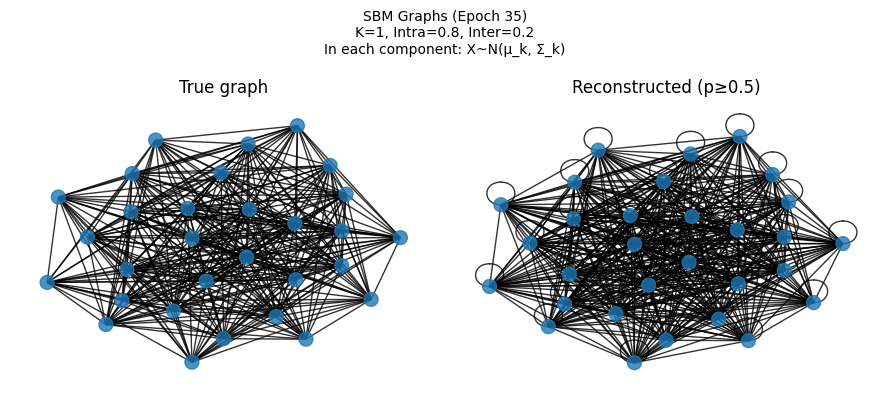

Epoch [36/100] - Total Loss: 5076197.3594, Recon Loss: 5074138.7188, KL Loss: 205.8648
Epoch [37/100] - Total Loss: 5076126.2188, Recon Loss: 5074173.2031, KL Loss: 195.3068
Epoch [38/100] - Total Loss: 5076151.4375, Recon Loss: 5074143.8438, KL Loss: 200.7601
Epoch [39/100] - Total Loss: 5076182.7500, Recon Loss: 5074299.0156, KL Loss: 188.3759
Epoch [40/100] - Total Loss: 5075485.8906, Recon Loss: 5073634.3750, KL Loss: 185.1477


Epoch [41/100] - Total Loss: 5074918.3125, Recon Loss: 5073176.7344, KL Loss: 174.1637
Epoch [42/100] - Total Loss: 5075370.5312, Recon Loss: 5073506.4219, KL Loss: 186.4159
Epoch [43/100] - Total Loss: 5074977.3750, Recon Loss: 5073192.6094, KL Loss: 178.4813
Epoch [44/100] - Total Loss: 5074840.1094, Recon Loss: 5073205.5312, KL Loss: 163.4550
Epoch [45/100] - Total Loss: 5075118.5781, Recon Loss: 5073450.7656, KL Loss: 166.7808


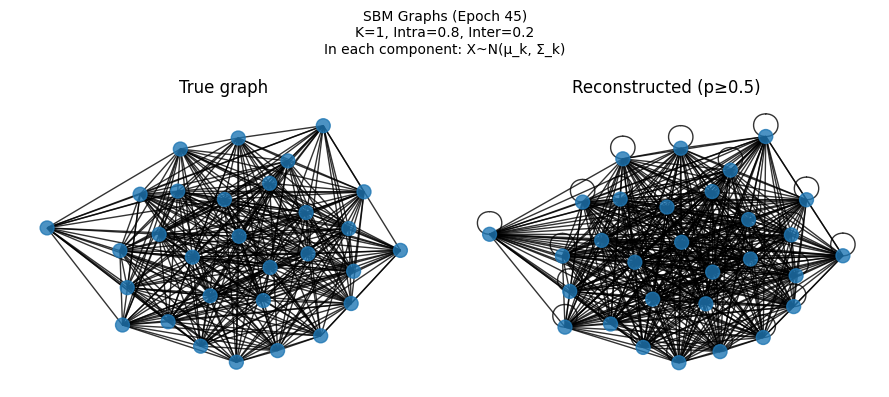

Epoch [46/100] - Total Loss: 5074643.9062, Recon Loss: 5073041.8281, KL Loss: 160.2089
Epoch [47/100] - Total Loss: 5073473.3281, Recon Loss: 5071888.2500, KL Loss: 158.5102
Epoch [48/100] - Total Loss: 5074349.5625, Recon Loss: 5072684.2812, KL Loss: 166.5224
Epoch [49/100] - Total Loss: 5074166.0938, Recon Loss: 5072644.8594, KL Loss: 152.1247
Epoch [50/100] - Total Loss: 5073735.7344, Recon Loss: 5072256.2656, KL Loss: 147.9377


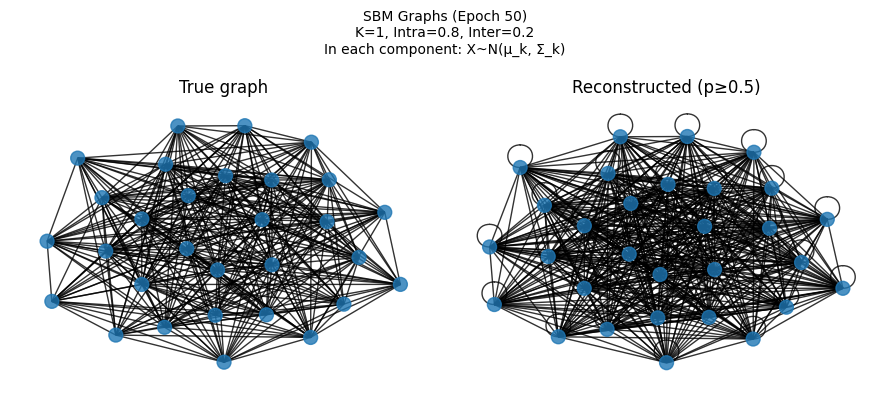

Epoch [51/100] - Total Loss: 5074356.8906, Recon Loss: 5072705.4062, KL Loss: 165.1430
Epoch [52/100] - Total Loss: 5073797.7656, Recon Loss: 5072330.7969, KL Loss: 146.7039
Epoch [53/100] - Total Loss: 5073458.8125, Recon Loss: 5072124.3281, KL Loss: 133.4417
Epoch [54/100] - Total Loss: 5073178.1562, Recon Loss: 5071658.6250, KL Loss: 151.9551
Epoch [55/100] - Total Loss: 5073255.5938, Recon Loss: 5071840.1406, KL Loss: 141.5415


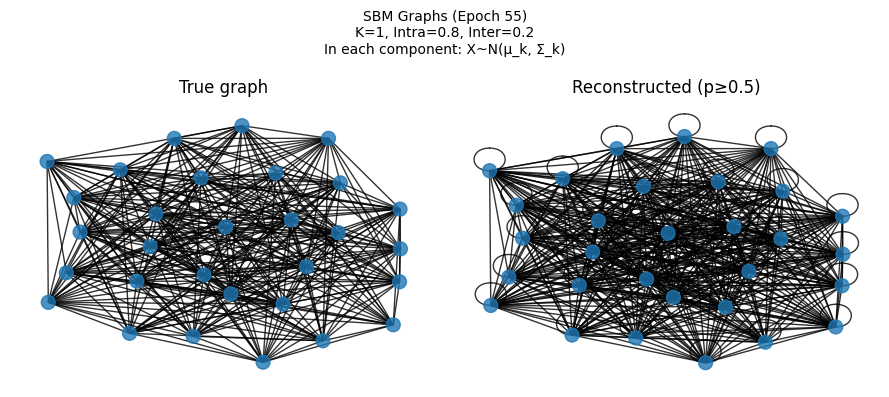

Epoch [56/100] - Total Loss: 5073509.6250, Recon Loss: 5072223.6094, KL Loss: 128.6019
Epoch [57/100] - Total Loss: 5073765.9062, Recon Loss: 5072375.8438, KL Loss: 139.0000
Epoch [58/100] - Total Loss: 5073096.2969, Recon Loss: 5071878.8281, KL Loss: 121.7445
Epoch [59/100] - Total Loss: 5072704.5000, Recon Loss: 5071462.6875, KL Loss: 124.1806
Epoch [60/100] - Total Loss: 5072368.3750, Recon Loss: 5071123.5312, KL Loss: 124.4879


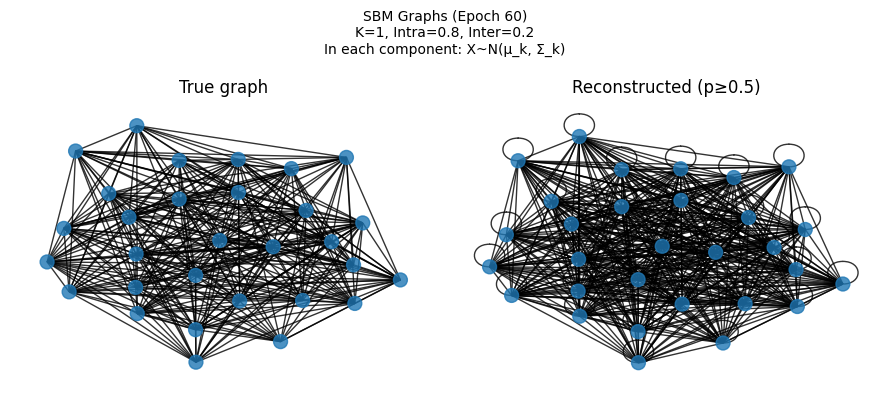

Epoch [61/100] - Total Loss: 5072636.8438, Recon Loss: 5071319.4844, KL Loss: 131.7342
Epoch [62/100] - Total Loss: 5073020.9375, Recon Loss: 5071784.9219, KL Loss: 123.6030
Epoch [63/100] - Total Loss: 5072607.0625, Recon Loss: 5071354.8594, KL Loss: 125.2259
Epoch [64/100] - Total Loss: 5071948.2500, Recon Loss: 5070818.1875, KL Loss: 113.0086
Epoch [65/100] - Total Loss: 5072748.0000, Recon Loss: 5071639.6875, KL Loss: 110.8282


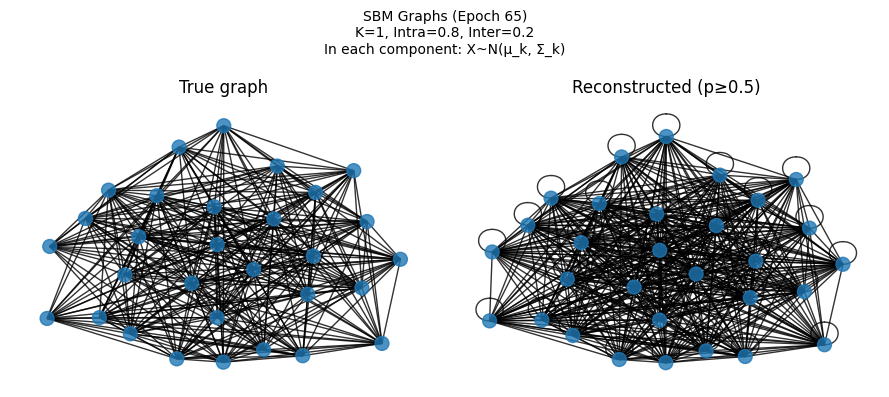

Epoch [66/100] - Total Loss: 5072124.1406, Recon Loss: 5071126.2812, KL Loss: 99.7900
Epoch [67/100] - Total Loss: 5072332.1562, Recon Loss: 5071099.7812, KL Loss: 123.2329
Epoch [68/100] - Total Loss: 5072141.6719, Recon Loss: 5071086.2969, KL Loss: 105.5380
Epoch [69/100] - Total Loss: 5072146.7031, Recon Loss: 5070936.0156, KL Loss: 121.0711
Epoch [70/100] - Total Loss: 5072458.8438, Recon Loss: 5071424.3594, KL Loss: 103.4569


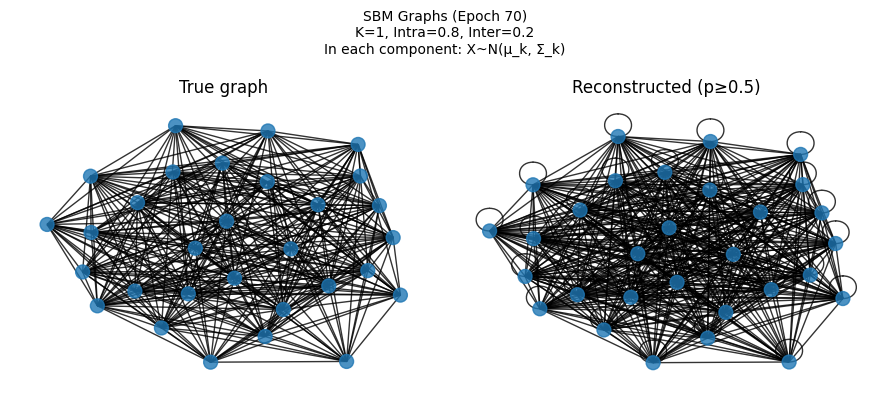

Epoch [71/100] - Total Loss: 5071896.3281, Recon Loss: 5070879.0000, KL Loss: 101.7375
Epoch [72/100] - Total Loss: 5071392.4531, Recon Loss: 5070308.5781, KL Loss: 108.3862
Epoch [73/100] - Total Loss: 5072177.2344, Recon Loss: 5071123.2500, KL Loss: 105.4039
Epoch [74/100] - Total Loss: 5071226.7188, Recon Loss: 5070190.5469, KL Loss: 103.6169
Epoch [75/100] - Total Loss: 5071351.6562, Recon Loss: 5070379.7656, KL Loss: 97.1885


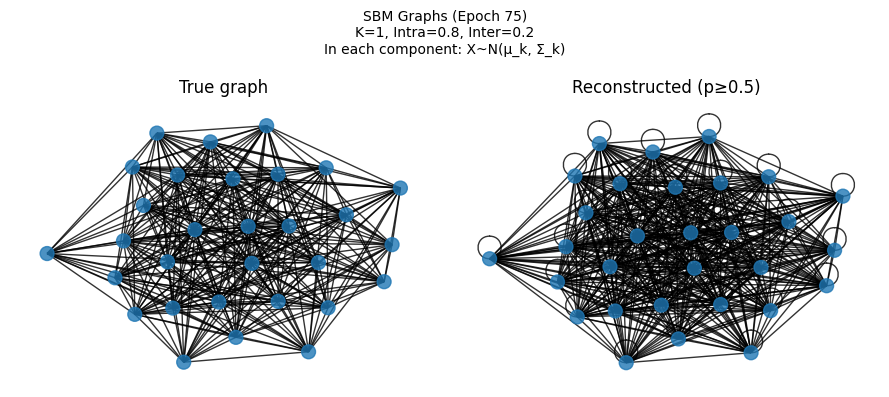

Epoch [76/100] - Total Loss: 5071602.5469, Recon Loss: 5070660.2656, KL Loss: 94.2235
Epoch [77/100] - Total Loss: 5071871.9219, Recon Loss: 5070803.9688, KL Loss: 106.7889
Epoch [78/100] - Total Loss: 5071199.2812, Recon Loss: 5070295.2812, KL Loss: 90.3936
Epoch [79/100] - Total Loss: 5070503.7031, Recon Loss: 5069629.9062, KL Loss: 87.3775
Epoch [80/100] - Total Loss: 5070991.4375, Recon Loss: 5070209.4531, KL Loss: 78.1968


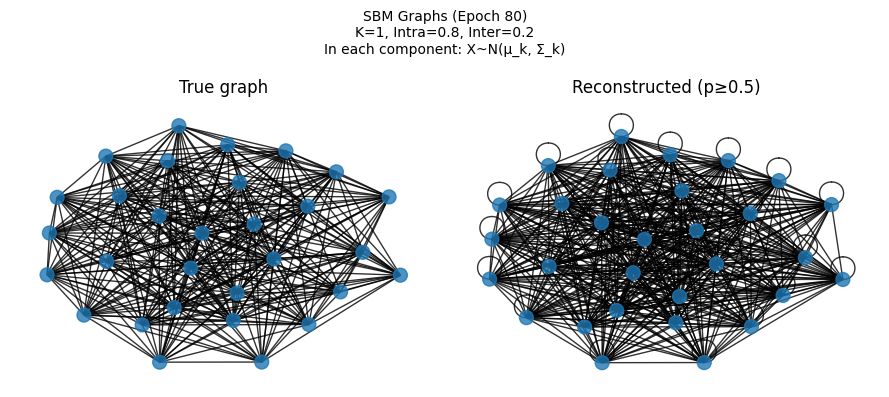

Epoch [81/100] - Total Loss: 5071677.2500, Recon Loss: 5070871.5156, KL Loss: 80.5722
Epoch [82/100] - Total Loss: 5071282.9375, Recon Loss: 5070472.8750, KL Loss: 81.0058
Epoch [83/100] - Total Loss: 5071134.2344, Recon Loss: 5070216.4531, KL Loss: 91.7782
Epoch [84/100] - Total Loss: 5070475.5156, Recon Loss: 5069538.9531, KL Loss: 93.6544
Epoch [85/100] - Total Loss: 5070570.4688, Recon Loss: 5069849.8125, KL Loss: 72.0716


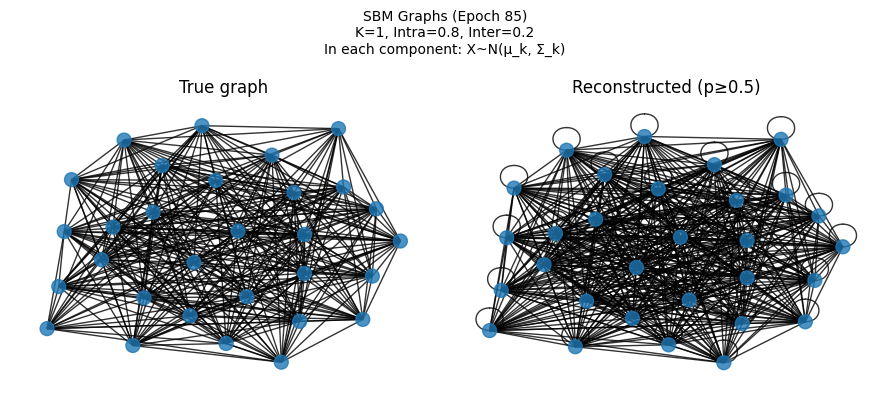

Epoch [86/100] - Total Loss: 5070683.0625, Recon Loss: 5069970.8594, KL Loss: 71.2227
Epoch [87/100] - Total Loss: 5071467.1094, Recon Loss: 5070693.6562, KL Loss: 77.3464
Epoch [88/100] - Total Loss: 5070745.2188, Recon Loss: 5069928.7500, KL Loss: 81.6575
Epoch [89/100] - Total Loss: 5070598.4219, Recon Loss: 5069935.0469, KL Loss: 66.3390
Epoch [90/100] - Total Loss: 5071209.7812, Recon Loss: 5070439.8125, KL Loss: 76.9947


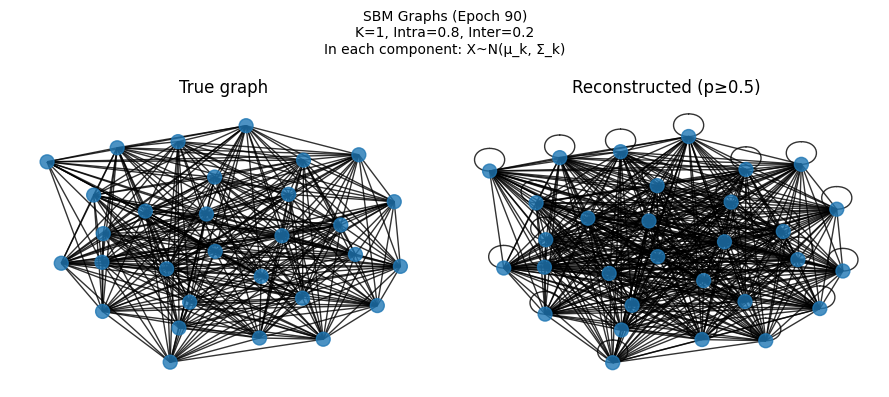

Epoch [91/100] - Total Loss: 5070632.5781, Recon Loss: 5069861.7188, KL Loss: 77.0816
Epoch [92/100] - Total Loss: 5070981.0469, Recon Loss: 5070192.8281, KL Loss: 78.8162
Epoch [93/100] - Total Loss: 5069778.8906, Recon Loss: 5069139.8281, KL Loss: 63.9023
Epoch [94/100] - Total Loss: 5069588.7188, Recon Loss: 5068988.0625, KL Loss: 60.0620
Epoch [95/100] - Total Loss: 5070415.1250, Recon Loss: 5069725.9688, KL Loss: 68.9101


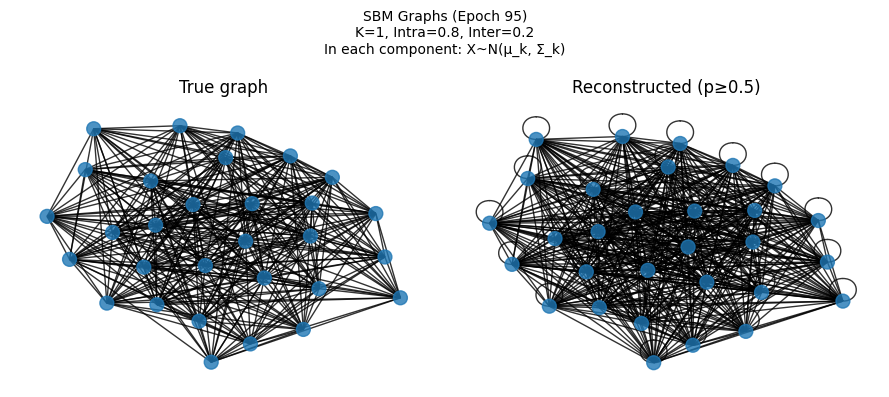

Epoch [96/100] - Total Loss: 5070277.6562, Recon Loss: 5069582.6875, KL Loss: 69.4932
Epoch [97/100] - Total Loss: 5070493.3125, Recon Loss: 5069817.8438, KL Loss: 67.5446
Epoch [98/100] - Total Loss: 5069855.0156, Recon Loss: 5069162.8906, KL Loss: 69.2074
Epoch [99/100] - Total Loss: 5069477.6875, Recon Loss: 5068783.8594, KL Loss: 69.3838
Epoch [100/100] - Total Loss: 5070036.4062, Recon Loss: 5069355.0000, KL Loss: 68.1423


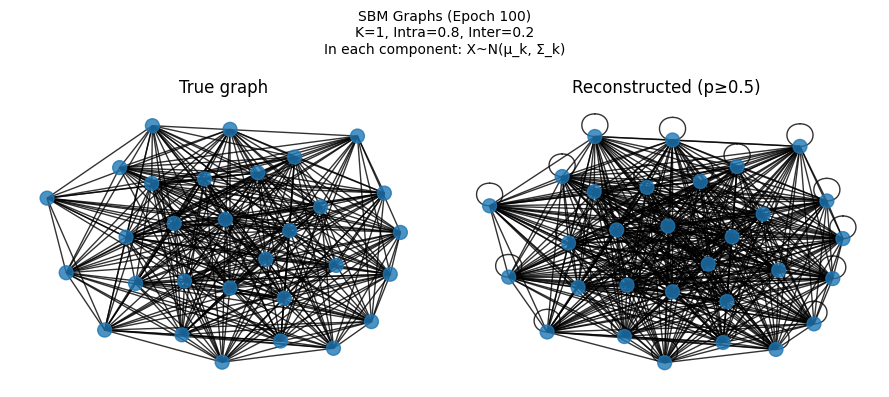

Testing the model...


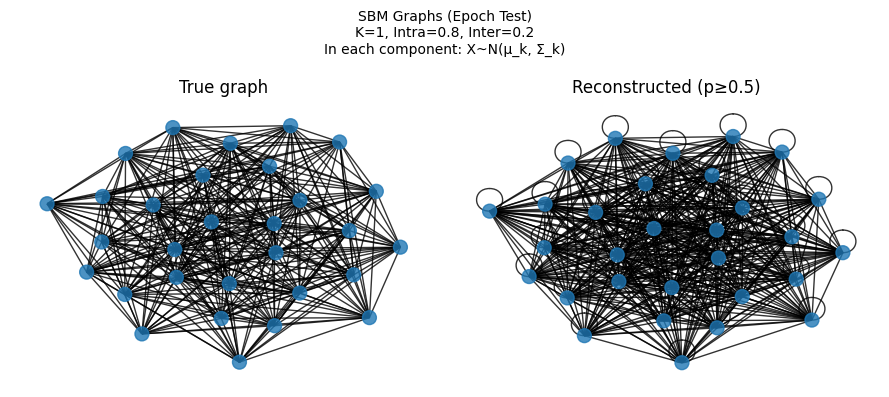

Average Edge Accuracy: 0.4870


In [9]:
def main():
    # Hyperparameters
    n_nodes = 30  # Number of nodes in the graph
    feat_dim = 4  # Dimensionality of node features
    z_dim = 16  # Latent space dimension
    epochs = 100  # Number of training epochs
    vis_interval = 5  # Interval for visualizing graphs during training
    kl_weight = 10.0  # KL divergence weight
    batch_size = 32  # Batch size for training
    learning_rate = 0.001  # Learning rate for the optimizer

    # Initialize model
    model = TemporalGraphVAE(n_nodes=n_nodes, feat_dim=feat_dim, z_dim=z_dim)
    model.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
    model.to(model.device)

    # Create a dataset (this should be replaced with a real dataset, here using synthetic data)
    dataset = SyntheticGraphDataset(n_nodes=n_nodes, feat_dim=feat_dim, T=40, n_seq=200, p_flip=0.03)

    # Create a DataLoader for batching
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    print("Training the model...")
    train_model(model=model, train_loader=train_loader, optimizer=optimizer, vis_interval=vis_interval, epochs=epochs, kl_weight=kl_weight)

    # Test the model
    print("Testing the model...")
    test_model(model=model, dataset=dataset)

if __name__ == "__main__":
    main()


# Question 2: Conditional Variational Autoencoder (CVAE) for Digit Generation


This note introduces a **Conditional Variational Autoencoder (CVAE)** for image generation on the **MNIST** dataset. The goal is to learn a deep latent-variable model that can synthesize digits conditioned on a desired label—e.g., generate a “2” on demand—and optionally modulate the writing style.


## **Problem setup**

We observe training pairs of handwritten digits and their class labels
$$
\mathcal{D} = {(x^{(i)}, y^{(i)})}_{i=1}^N,
$$
where $x^{(i)} \in \mathbb{R}^{28\times28}$ is an image and $y^{(i)} \in {0,\dots,9}$ is the corresponding digit label.
Our goal is to model the conditional data distribution
$$
p_\theta(x \mid y),
$$
so that, given any label $y$, the model can generate realistic samples $x$ of that digit.



In [10]:
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import numpy as np
from matplotlib.gridspec import GridSpec

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.48MB/s]


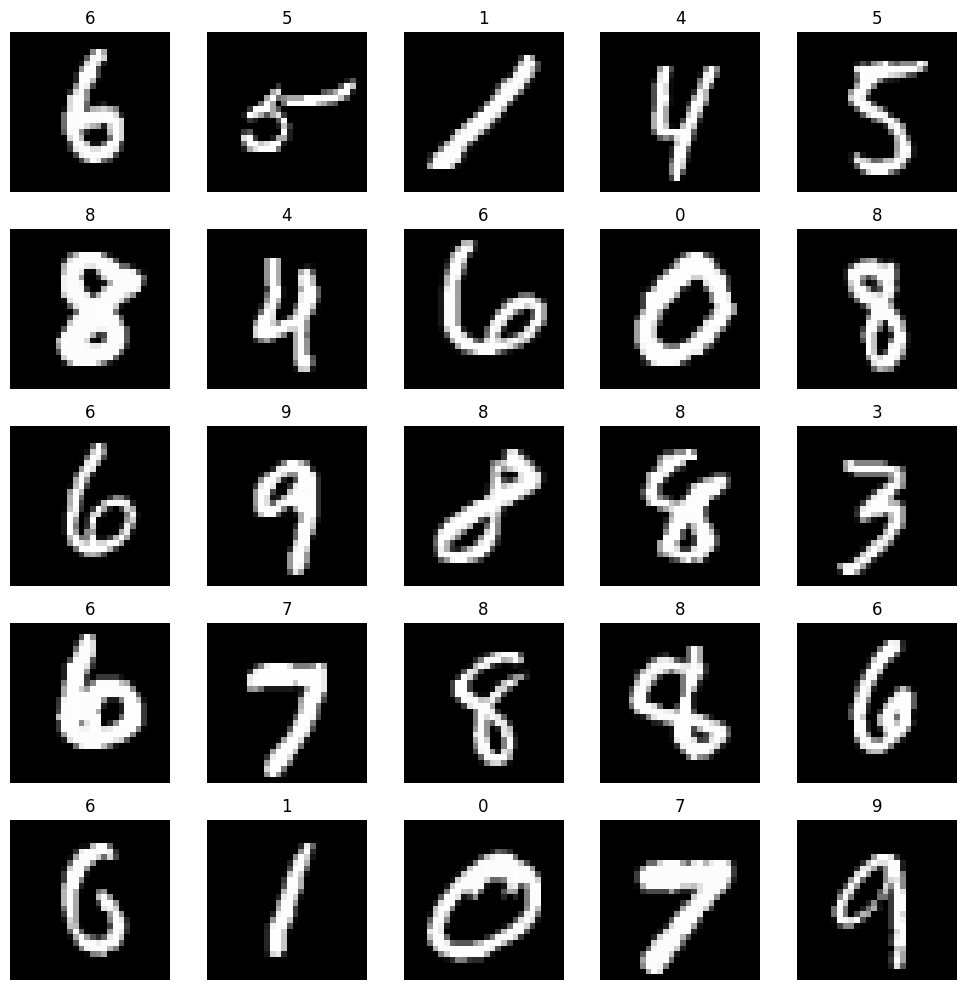

In [11]:
# TODO: data visualization
# create a 5x5 grid and show different images with their labels

# Load MNIST dataset for visualization
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a 5x5 grid of random samples
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        # Select a random image from the dataset
        idx = random.randint(0, len(mnist_dataset) - 1)
        image, label = mnist_dataset[idx]
        
        # Convert tensor to numpy array for plotting
        img_array = image.squeeze().numpy()
        
        # Plot the image
        axes[i, j].imshow(img_array, cmap='gray')
        axes[i, j].set_title(f"{label}", fontsize=12)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

### **Model setup**

We introduce a latent variable $ z \in \mathbb{R}^m $ that captures continuous variations in handwriting style.
The joint distribution is defined as

$$
p_\theta(x, z \mid y) = p_\theta(x \mid z, y) p(z),
$$

where $ p(z) = \mathcal{N}(0, I) $ is a fixed Gaussian prior.

* **Decoder (generative model):** $ p_\theta(x \mid z, y) $ reconstructs the image given latent code $z$ and label $y$.
* **Encoder (inference model):** we approximate the true posterior $ p_\theta(z \mid x, y) $ with

$$
q_\phi(z \mid x, y) = \mathcal{N}\big(\mu_\phi(x, y), \mathrm{diag}(\sigma_\phi^2(x, y))\big).
$$



### **Derivation of the Conditional ELBO**

Our goal is to maximize the conditional log-likelihood of the data:

$$
\log p_\theta(x \mid y).
$$

Since this is intractable, we derive a lower bound (the **conditional ELBO**):

$$
\log p_\theta(x \mid y)
\ge
\mathbb{E}_{q_\phi(z \mid x, y)}[\log p_\theta(x \mid z, y)]

D_{\mathrm{KL}}\big(q_\phi(z \mid x, y) | p(z)\big).
$$

### **Training objective**

The right-hand side is the objective we actually optimize.
We **maximize** the ELBO with respect to parameters $\theta$ and $\phi$, or equivalently, **minimize** the negative ELBO (which is used as the loss in code):

$$
\mathcal{L}_{\text{CVAE}}(x, y)
= -\mathbb{E}_{q_\phi(z \mid x, y)}[\log p_\theta(x \mid z, y)]
+ D_{\mathrm{KL}}\big(q_\phi(z \mid x, y) | p(z)\big).
$$

- The first term (reconstruction loss) ensures that decoded samples resemble the input image.
- The second term (KL divergence) regularizes the latent distribution so that it stays close to the Gaussian prior, which keeps sampling stable during generation.




In [12]:
def to_one_hot(labels, num_classes=10):
    """Convert integer labels to one-hot vectors"""
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes, device=labels.device)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

class Encoder(nn.Module):
    def __init__(self, y_dim=10, z_dim=32, hidden_dims=[512, 256, 128]):
        """
        Deeper encoder with multiple fully connected layers
        
        Args:
            y_dim: Dimension of label embedding (10 for MNIST)
            z_dim: Dimension of latent space
            hidden_dims: List of hidden layer dimensions [layer1, layer2, ...]
        """
        super().__init__()
        self.y_dim = y_dim
        
        # Input: image (784) + one-hot label (y_dim)
        self.input_dim = 784 + y_dim
        
        # Build encoder layers dynamically
        layers = []
        prev_dim = self.input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layers for mu and logvar
        self.fc_mu = nn.Linear(prev_dim, z_dim)
        self.fc_logvar = nn.Linear(prev_dim, z_dim)
        
    def forward(self, x, y_one_hot):
        # Flatten image and concatenate with one-hot label
        x_flat = x.view(x.size(0), -1)
        h = torch.cat([x_flat, y_one_hot], dim=1)
        
        # Pass through hidden layers
        h = self.hidden_layers(h)
        
        # Output mu and logvar
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, y_dim=10, z_dim=32, hidden_dims=[128, 256, 512]):
        """
        Deeper decoder with multiple fully connected layers
        
        Args:
            y_dim: Dimension of label embedding (10 for MNIST)
            z_dim: Dimension of latent space
            hidden_dims: List of hidden layer dimensions [layer1, layer2, ...]
        """
        super().__init__()
        self.y_dim = y_dim
        
        # Input: latent code (z_dim) + one-hot label (y_dim)
        self.input_dim = z_dim + y_dim
        
        # Build decoder layers dynamically
        layers = []
        prev_dim = self.input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
            prev_dim = hidden_dim
        
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layer (to image dimensions)
        self.fc_output = nn.Linear(prev_dim, 784)
        
    def forward(self, z, y_one_hot):
        # Concatenate latent code and one-hot label
        h = torch.cat([z, y_one_hot], dim=1)
        
        # Pass through hidden layers
        h = self.hidden_layers(h)
        
        # Output layer with sigmoid activation for pixel values [0, 1]
        reconstruction = torch.sigmoid(self.fc_output(h))
        
        # Reshape to image dimensions
        return reconstruction.view(-1, 1, 28, 28)


class CVAE(nn.Module):
    def __init__(self, y_dim=10, z_dim=32, enc_hidden_dims=[512, 256, 128], 
                 dec_hidden_dims=[128, 256, 512]):
        super().__init__()
        self.z_dim = z_dim
        self.y_dim = y_dim
        
        # Create deep encoder and decoder
        self.encoder = Encoder(y_dim, z_dim, enc_hidden_dims)
        self.decoder = Decoder(y_dim, z_dim, dec_hidden_dims)
        
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def forward(self, x, y):
        # Convert integer labels to one-hot
        y_one_hot = to_one_hot(y, self.y_dim)
        
        # Encode
        mu, logvar = self.encoder(x, y_one_hot)
        
        # Reparameterize
        z = self.reparameterize(mu, logvar)
        
        # Decode
        recon_x = self.decoder(z, y_one_hot)
        
        return recon_x, mu, logvar
    
    def sample(self, y, num_samples=1, device='cpu'):
        """Generate samples from prior"""
        with torch.no_grad():
            # Convert integer labels to one-hot
            y_one_hot = to_one_hot(y, self.y_dim)
            
            # Sample from prior
            z = torch.randn(num_samples, self.z_dim, device=device)
            
            # Decode
            generated = self.decoder(z, y_one_hot)
            return generated

In [13]:
def loss_function(x_recon, x, mu, logvar, reduction='sum'):
    batch_size = x.size(0)
    
    # Reconstruction loss (binary cross-entropy)
    x_flat = x.view(batch_size, -1)
    x_recon_flat = x_recon.view(batch_size, -1)
    
    recon_loss = F.binary_cross_entropy(x_recon_flat, x_flat, reduction='none')
    recon_loss = recon_loss.sum(dim=1)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    
    total_per_sample = recon_loss + kl_loss
    
    if reduction == 'sum':
        total_loss = total_per_sample.sum()
        recon_loss = recon_loss.sum()
        kl_loss = kl_loss.sum()
    elif reduction == 'mean':
        total_loss = total_per_sample.mean()
        recon_loss = recon_loss.mean()
        kl_loss = kl_loss.mean()
    else:
        total_loss = total_per_sample
    
    return total_loss, recon_loss, kl_loss

Using device: cuda
Loading datasets...
Train samples: 60000
Test samples: 10000

Initializing model...
Total parameters: 1,155,408
Trainable parameters: 1,155,408

Starting training...

Epoch 1/3
--------------------------------------------------
Training...


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  Batch 100/469 - Loss: 166.7946, Recon: 156.2715, KL: 10.5231
  Batch 200/469 - Loss: 153.3244, Recon: 142.6464, KL: 10.6779
  Batch 300/469 - Loss: 147.5645, Recon: 136.5411, KL: 11.0234
  Batch 400/469 - Loss: 144.7585, Recon: 134.4061, KL: 10.3523

Validating...
  Val Batch 50/79 - Avg Loss: 134.8582

Epoch 1 Summary:
  Train Loss: 163.7028 (Recon: 153.7826, KL: 9.9202)
  Val Loss: 131.9678
  Learning Rate: 0.001000
  ✓ Saved best model with val loss: 131.9678

Epoch 2/3
--------------------------------------------------
Training...
  Batch 100/469 - Loss: 136.9287, Recon: 126.7526, KL: 10.1761
  Batch 200/469 - Loss: 137.0604, Recon: 126.8729, KL: 10.1874
  Batch 300/469 - Loss: 133.3177, Recon: 123.4209, KL: 9.8968
  Batch 400/469 - Loss: 134.5753, Recon: 124.0443, KL: 10.5310

Validating...
  Val Batch 50/79 - Avg Loss: 123.3477

Epoch 2 Summary:
  Train Loss: 137.1967 (Recon: 126.9074, KL: 10.2892)
  Val Loss: 121.4810
  Learning Rate: 0.001000
  ✓ Saved best model with val los

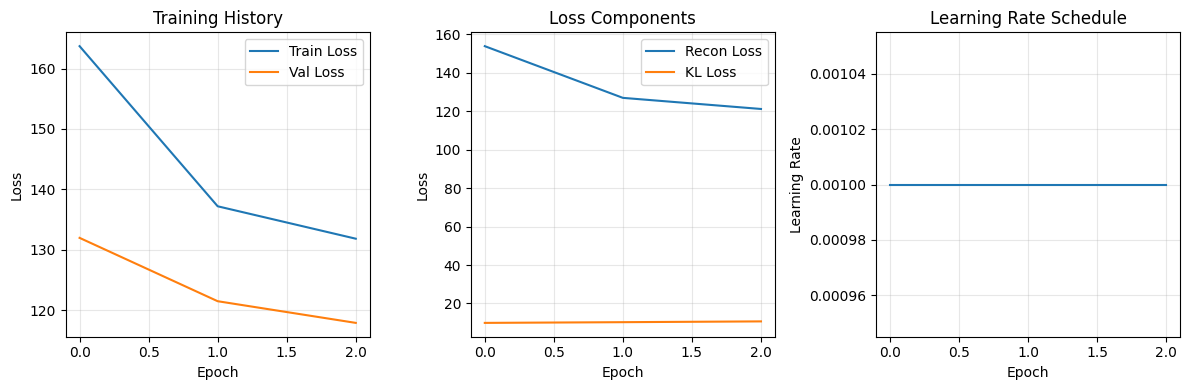

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os

# Define one-hot encoding function
def to_one_hot(labels, num_classes=10):
    """Convert integer labels to one-hot vectors"""
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes, device=labels.device)
    one_hot.scatter_(1, labels.unsqueeze(1), 1)
    return one_hot

# Define loss function
def loss_function(x_recon, x, mu, logvar, reduction='sum'):
    batch_size = x.size(0)
    
    # Reconstruction loss (binary cross-entropy)
    x_flat = x.view(batch_size, -1)
    x_recon_flat = x_recon.view(batch_size, -1)
    
    recon_loss = F.binary_cross_entropy(x_recon_flat, x_flat, reduction='none')
    recon_loss = recon_loss.sum(dim=1)
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    
    total_per_sample = recon_loss + kl_loss
    
    if reduction == 'sum':
        total_loss = total_per_sample.sum()
        recon_loss = recon_loss.sum()
        kl_loss = kl_loss.sum()
    elif reduction == 'mean':
        total_loss = total_per_sample.mean()
        recon_loss = recon_loss.mean()
        kl_loss = kl_loss.mean()
    else:
        total_loss = total_per_sample
    
    return total_loss, recon_loss, kl_loss

# Function to get dataloaders
def get_dataloaders(batch_size=128, root='./data'):
    """Create train and test dataloaders for MNIST"""
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    train_dataset = datasets.MNIST(root=root, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=root, train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

# Training function
def train_epoch(model, train_loader, optimizer, device, clip_grad=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        x_recon, mu, logvar = model(x, y)

        loss, recon_loss, kl_loss = loss_function(x_recon, x, mu, logvar, reduction='mean')
        loss.backward()
        
        # Gradient clipping for stability
        if clip_grad > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        
        optimizer.step()

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_recon += recon_loss.item() * batch_size
        total_kl += kl_loss.item() * batch_size
        
        # Print progress every 100 batches
        if (batch_idx + 1) % 100 == 0:
            print(f"  Batch {batch_idx + 1}/{len(train_loader)} - "
                  f"Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, KL: {kl_loss.item():.4f}")
    
    avg_loss = total_loss / len(train_loader.dataset)
    avg_recon = total_recon / len(train_loader.dataset)
    avg_kl = total_kl / len(train_loader.dataset)
    
    return avg_loss, avg_recon, avg_kl

# Validation function
def validate(model, test_loader, device):
    """Validate the model"""
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)
            x_recon, mu, logvar = model(x, y)
            loss, _, _ = loss_function(x_recon, x, mu, logvar, reduction='sum')
            total_loss += loss.item()
            
            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"  Val Batch {batch_idx + 1}/{len(test_loader)} - "
                      f"Avg Loss: {loss.item()/x.size(0):.4f}")
    
    avg_loss = total_loss / len(test_loader.dataset)
    return avg_loss

# Main training function
def train_cvae(model, train_loader, test_loader, device, 
               epochs=30, lr=1e-3, weight_decay=1e-5, 
               clip_grad=1.0, patience=5, save_path='cvae_mnist_best.pth'):
    """Main training loop for CVAE"""
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience, verbose=True
    )
    
    best_loss = float('inf')
    history = {
        'train_loss': [], 'train_recon': [], 'train_kl': [],
        'val_loss': [], 'lr': []
    }
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        print("-" * 50)
        
        # Training phase
        print("Training...")
        train_loss, train_recon, train_kl = train_epoch(
            model, train_loader, optimizer, device, clip_grad
        )
        
        # Validation phase
        print("\nValidating...")
        val_loss = validate(model, test_loader, device)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_recon'].append(train_recon)
        history['train_kl'].append(train_kl)
        history['val_loss'].append(val_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f"\nEpoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f} (Recon: {train_recon:.4f}, KL: {train_kl:.4f})")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Learning Rate: {history['lr'][-1]:.6f}")
        
        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'history': history,
            }, save_path)
            print(f"  ✓ Saved best model with val loss: {best_loss:.4f}")
            
            # Optional: Save checkpoint
            checkpoint_path = save_path.replace('.pth', f'_epoch_{epoch}.pth')
            torch.save(model.state_dict(), checkpoint_path)
    
    print(f"\nTraining completed! Best validation loss: {best_loss:.4f}")
    
    return history

# Function to load best model
def load_best_model(model_class, save_path, device, **model_kwargs):
    """Load the best saved model"""
    checkpoint = torch.load(save_path, map_location=device)
    model = model_class(**model_kwargs).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model, checkpoint

# Main execution
if __name__ == "__main__":
    # Set parameters
    batch_size = 128
    epochs = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print(f"Using device: {device}")
    
    # Get dataloaders
    print("Loading datasets...")
    train_loader, test_loader = get_dataloaders(batch_size=batch_size)
    print(f"Train samples: {len(train_loader.dataset)}")
    print(f"Test samples: {len(test_loader.dataset)}")
    
    # Initialize model
    print("\nInitializing model...")
    model = CVAE(
        y_dim=10,
        z_dim=32,
        enc_hidden_dims=[512, 256, 128],
        dec_hidden_dims=[128, 256, 512]
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Train model
    print("\nStarting training...")
    history = train_cvae(
        model=model,
        train_loader=train_loader,
        test_loader=test_loader,
        device=device,
        epochs=epochs,
        lr=1e-3,
        weight_decay=1e-5,
        clip_grad=1.0,
        patience=5,
        save_path='cvae_mnist_best.pth'
    )
    
    # Plot training history (optional)
    try:
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 2)
        plt.plot(history['train_recon'], label='Recon Loss')
        plt.plot(history['train_kl'], label='KL Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Components')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 3, 3)
        plt.plot(history['lr'])
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=150)
        plt.show()
        
    except ImportError:
        print("Matplotlib not available. Skipping plots.")

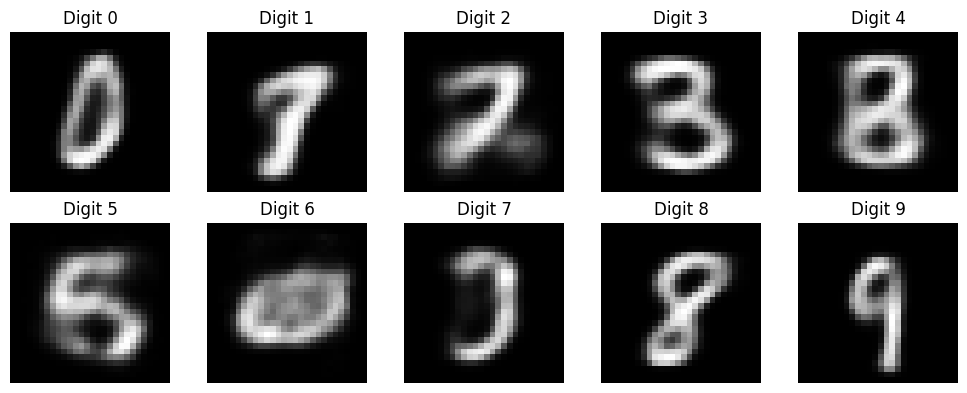

In [15]:
# Generate and visualize samples after training
model.eval()
with torch.no_grad():
    # Generate digits 0-9
    z = torch.randn(10, model.z_dim, device=device)
    labels = torch.arange(0, 10, device=device)
    y_one_hot = to_one_hot(labels, 10)
    generated = model.decoder(z, y_one_hot)

    # Visualize generated digits
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated[i].squeeze().cpu().numpy(), cmap='gray')
        ax.set_title(f"Digit {i}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Student ID Generation
After training your CVAE model, define a function that takes your 9-digit student ID as input and generates one digit per number in your ID. Each digit must be conditioned on its corresponding label (0–9). Arrange the generated digits horizontally in a 1×9 grid to visually display your complete student ID as a sequence of generated MNIST-style digits. Include this final generated image in your report.


Generating Student ID Digits (Simple Version)
Generating digits for student ID: 400101967
Individual digits: [4, 0, 0, 1, 0, 1, 9, 6, 7]
Generated image saved as: student_id_400101967_generated.png


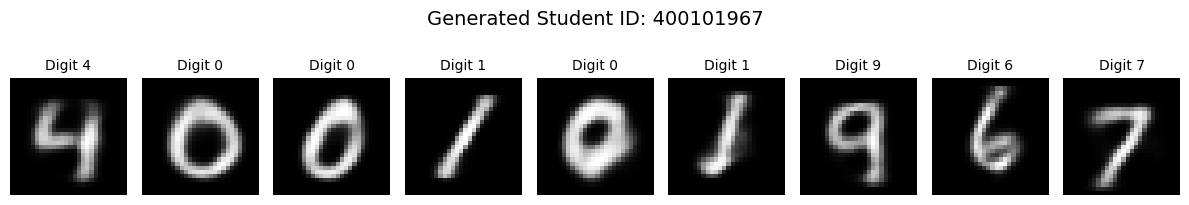

In [16]:
def generate_student_digits(model, student_id, device='cpu'):
    """
    Generate MNIST-style digits for each digit in the student ID
    
    Args:
        model: Trained CVAE model
        student_id: Integer student ID (e.g., 404405406)
        device: Device to run the model on
    
    Returns:
        Generated image grid and individual digit tensors
    """
    # Convert student ID to string to extract digits
    id_str = str(student_id)
    
    # Ensure the ID has exactly 9 digits
    if len(id_str) != 9:
        raise ValueError(f"Student ID must be 9 digits, got {len(id_str)} digits: {student_id}")
    
    # Extract individual digits
    digits = [int(d) for d in id_str]
    print(f"Generating digits for student ID: {student_id}")
    print(f"Individual digits: {digits}")
    
    # Move model to device and set to evaluation mode
    model = model.to(device)
    model.eval()
    
    # Generate digits
    generated_digits = []
    with torch.no_grad():
        for digit in digits:
            # Create label tensor for this digit
            label_tensor = torch.tensor([digit], device=device)
            
            # Convert to one-hot encoding
            y_one_hot = to_one_hot(label_tensor, 10)
            
            # Sample from latent space
            z = torch.randn(1, model.z_dim, device=device)
            
            # Generate the digit
            generated = model.decoder(z, y_one_hot)
            
            # Remove batch dimension and move to CPU
            generated_digit = generated.squeeze(0).cpu()
            generated_digits.append(generated_digit)
    
    # Create figure for the 1x9 grid
    fig, axes = plt.subplots(1, 9, figsize=(12, 2))
    fig.suptitle(f'Generated Student ID: {student_id}', fontsize=14, y=1.05)
    
    # Plot each generated digit
    for i, (ax, digit_img, true_digit) in enumerate(zip(axes, generated_digits, digits)):
        # Convert tensor to numpy for plotting
        img_array = digit_img.squeeze().numpy()  # Remove channel dimension
        
        # Plot the image
        ax.imshow(img_array, cmap='gray')
        ax.set_title(f'Digit {true_digit}', fontsize=10)
        ax.axis('off')
        
        # Add border around each subplot
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)
    
    plt.tight_layout()
    
    # Save the generated image
    output_filename = f'student_id_{student_id}_generated.png'
    plt.savefig(output_filename, dpi=150, bbox_inches='tight')
    print(f"Generated image saved as: {output_filename}")
    
    plt.show()
    
    return generated_digits, fig

# Additional utility function to create a single concatenated image
def create_student_id_image(generated_digits, student_id, save_path=None):
    """
    Create a single concatenated image of all generated digits
    """
    # Convert all digits to numpy arrays and remove channel dimension
    digit_arrays = [digit.squeeze().numpy() for digit in generated_digits]
    
    # Concatenate horizontally
    concatenated = np.concatenate(digit_arrays, axis=1)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 1.5))
    
    # Display concatenated image
    ax.imshow(concatenated, cmap='gray')
    ax.set_title(f'Student ID: {student_id} (Concatenated)', fontsize=12)
    ax.axis('off')
    
    # Add a border around the entire image
    rect = plt.Rectangle((-0.5, -0.5), concatenated.shape[1], concatenated.shape[0], 
                         linewidth=2, edgecolor='black', facecolor='none')
    ax.add_patch(rect)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Concatenated image saved as: {save_path}")
    
    plt.show()
    
    return concatenated, fig

# Function to generate multiple samples for each digit (for selection)
def generate_digit_samples(model, digit, num_samples=5, device='cpu'):
    """
    Generate multiple samples of a specific digit
    """
    model.eval()
    samples = []
    
    with torch.no_grad():
        # Create label tensor
        label_tensor = torch.tensor([digit] * num_samples, device=device)
        y_one_hot = to_one_hot(label_tensor, 10)
        
        # Sample from latent space
        z = torch.randn(num_samples, model.z_dim, device=device)
        
        # Generate digits
        generated = model.decoder(z, y_one_hot).cpu()
        
        # Remove batch dimension
        for i in range(num_samples):
            samples.append(generated[i])
    
    return samples

# Function to generate the best-looking student ID from multiple samples
def generate_best_student_id(model, student_id, num_samples_per_digit=3, device='cpu'):
    """
    Generate multiple samples for each digit and select the best-looking ones
    """
    id_str = str(student_id)
    digits = [int(d) for d in id_str]
    
    print(f"Generating {num_samples_per_digit} samples for each digit in ID: {student_id}")
    
    all_samples = []
    selected_samples = []
    
    # Generate multiple samples for each digit
    for digit in digits:
        samples = generate_digit_samples(model, digit, num_samples_per_digit, device)
        all_samples.append(samples)
        
        # For simplicity, select the first sample
        # In practice, you might want to implement a selection criterion
        selected_samples.append(samples[0])
    
    # Display all samples
    fig, axes = plt.subplots(len(digits), num_samples_per_digit + 1, figsize=(12, 8))
    fig.suptitle(f'Student ID {student_id} - Multiple Samples per Digit', fontsize=14)
    
    for i, (digit, samples) in enumerate(zip(digits, all_samples)):
        # Plot each sample
        for j, sample in enumerate(samples):
            ax = axes[i, j]
            img_array = sample.squeeze().numpy()
            ax.imshow(img_array, cmap='gray')
            ax.axis('off')
            
            # Highlight the selected sample
            if j == 0:
                ax.set_title(f'Digit {digit} (Selected)', fontsize=10, color='red')
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(2)
            else:
                ax.set_title(f'Sample {j+1}', fontsize=8)
        
        # Show the true digit in the last column for reference
        ax_ref = axes[i, -1]
        # Load a real MNIST digit for comparison (optional)
        ax_ref.text(0.5, 0.5, str(digit), fontsize=40, ha='center', va='center')
        ax_ref.axis('off')
        ax_ref.set_title('True Digit', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'student_id_{student_id}_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Create the final student ID image from selected samples
    selected_image, _ = create_student_id_image(
        selected_samples, 
        student_id, 
        save_path=f'student_id_{student_id}_selected.png'
    )
    
    return selected_samples, selected_image

# Example usage
if __name__ == "__main__":
    # Assuming you have a trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load your trained model
    # model = CVAE(...).to(device)
    # model.load_state_dict(torch.load('cvae_mnist_best.pth')['model_state_dict'])
    
    # Example student ID (replace with your actual ID)
    student_id = 400101967  # Replace with your 9-digit student ID
    
    # Generate simple version
    print("\n" + "="*60)
    print("Generating Student ID Digits (Simple Version)")
    print("="*60)
    generated_digits, fig = generate_student_digits(model, student_id, device)
    

### **Latent Space Exploration**
To demonstrate that your CVAE has learned a meaningful latent representation, write a function that visualizes the latent space of the model.
Select **two random latent directions** in $z$-space, fix a target digit label $y$, and generate a **9×9 grid** of samples by varying these two directions from negative to positive values.
The center of the grid should correspond to $z = 0$ (the mean latent vector), while moving along the axes explores different variations of handwriting style.
After visualizing, **describe what each direction appears to represent**—for example, changes in stroke thickness, slant, or digit shape—and discuss whether the transformations look smooth and interpretable.


LATENT SPACE EXPLORATION FOR CONDITIONAL VAE

Exploring latent space for digit 2 (1/2)


/tmp/ipykernel_48/1156833684.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Latent space visualization saved as: latent_space_digit_2_dims_14_26.png


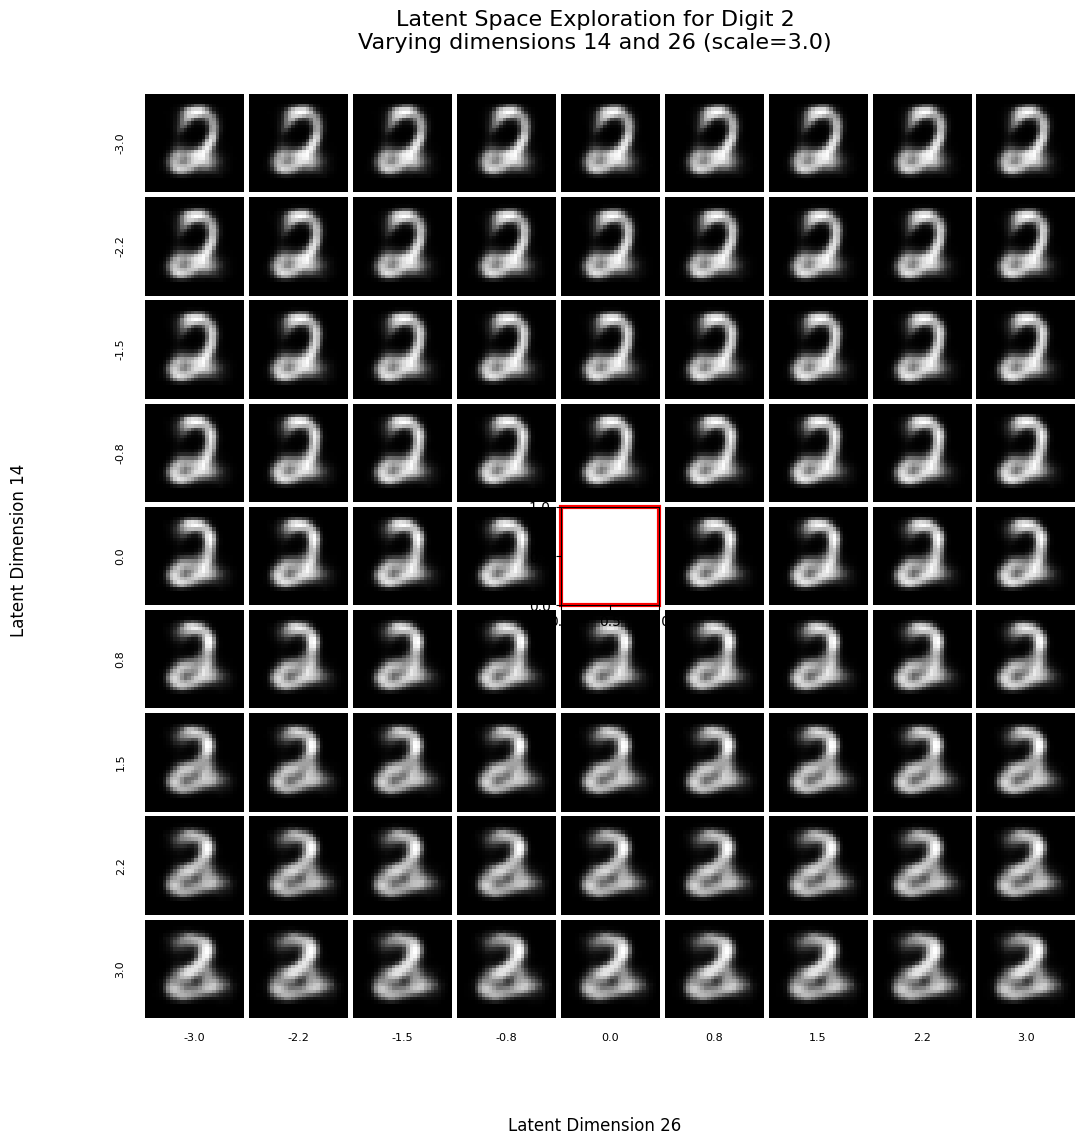

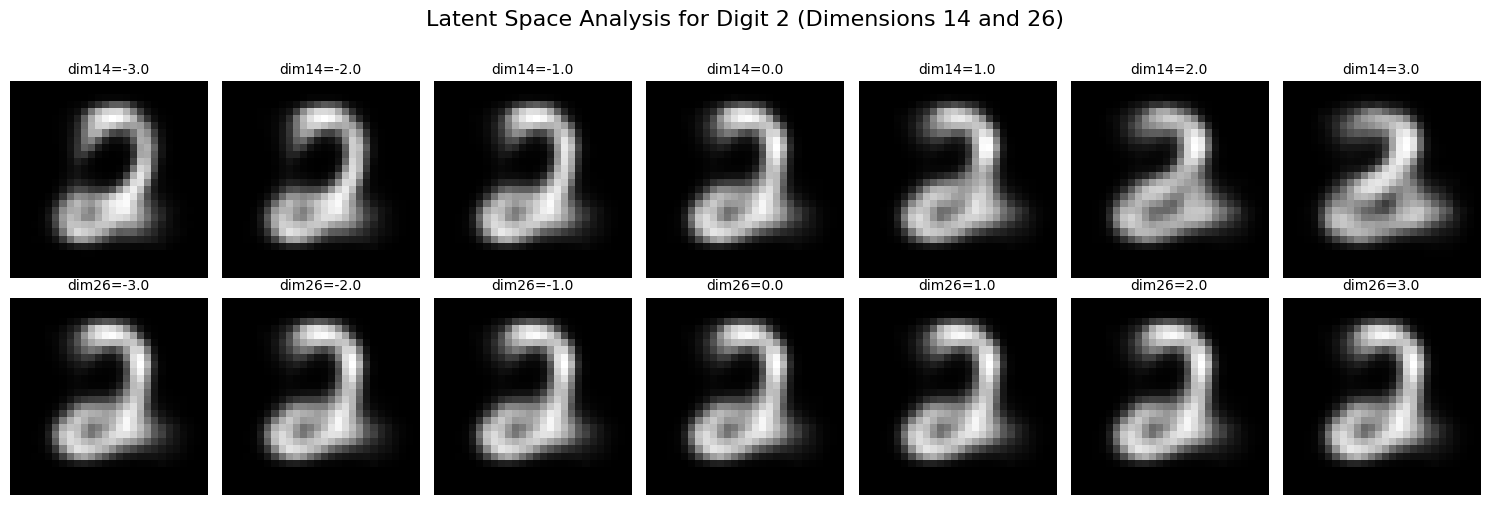


INTERPRETATION OF LATENT DIMENSIONS 14 AND 26 FOR DIGIT 2

Generating extreme samples for analysis...


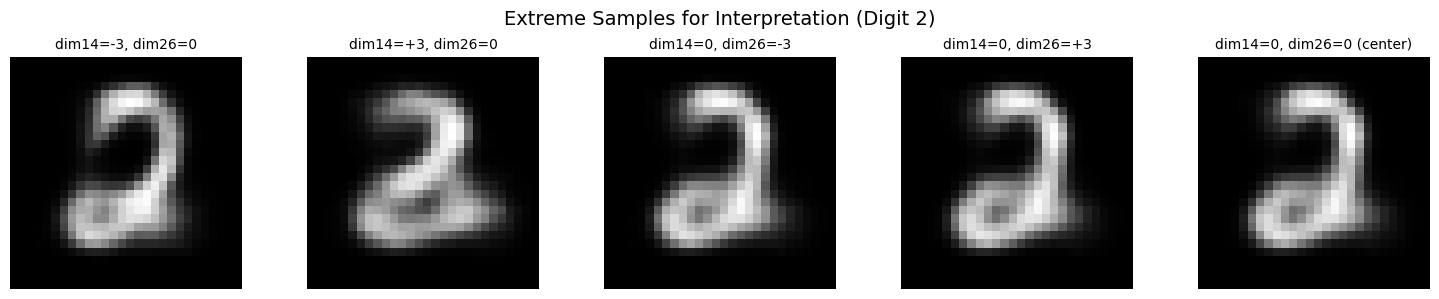


INTERPRETATION FRAMEWORK:

Dimension 14 appears to control:
- Positive values: [Describe visual characteristics]
- Negative values: [Describe visual characteristics]
- Observation: [Note smoothness, realism, etc.]

Dimension 26 appears to control:
- Positive values: [Describe visual characteristics]
- Negative values: [Describe visual characteristics]
- Observation: [Note smoothness, realism, etc.]

OVERALL ASSESSMENT:
- Are the transitions between samples smooth and continuous?
- Do the variations make visual sense (gradual changes in specific features)?
- Are there any artifacts or unrealistic generations at extremes?
- Does the model maintain digit identity while varying style?
- Are the learned representations interpretable?

EXAMPLE INTERPRETATION TEMPLATE:
--------------------------------------------------
For digit 2 and latent dimensions 14 and 26:

Dimension 14 appears to control: [e.g., stroke thickness]
- Positive values: Thicker strokes, darker appearance
- Negative values

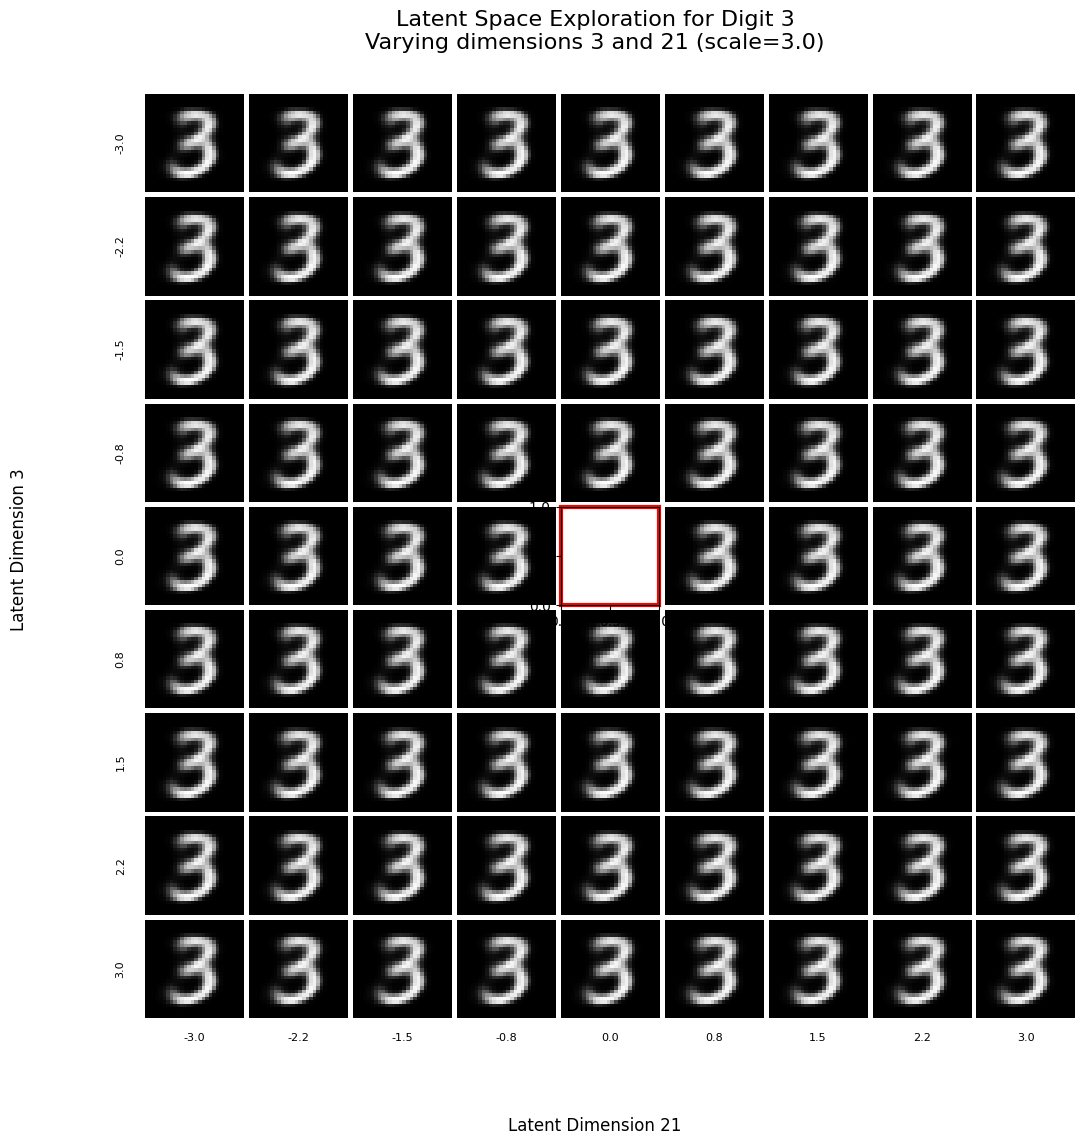

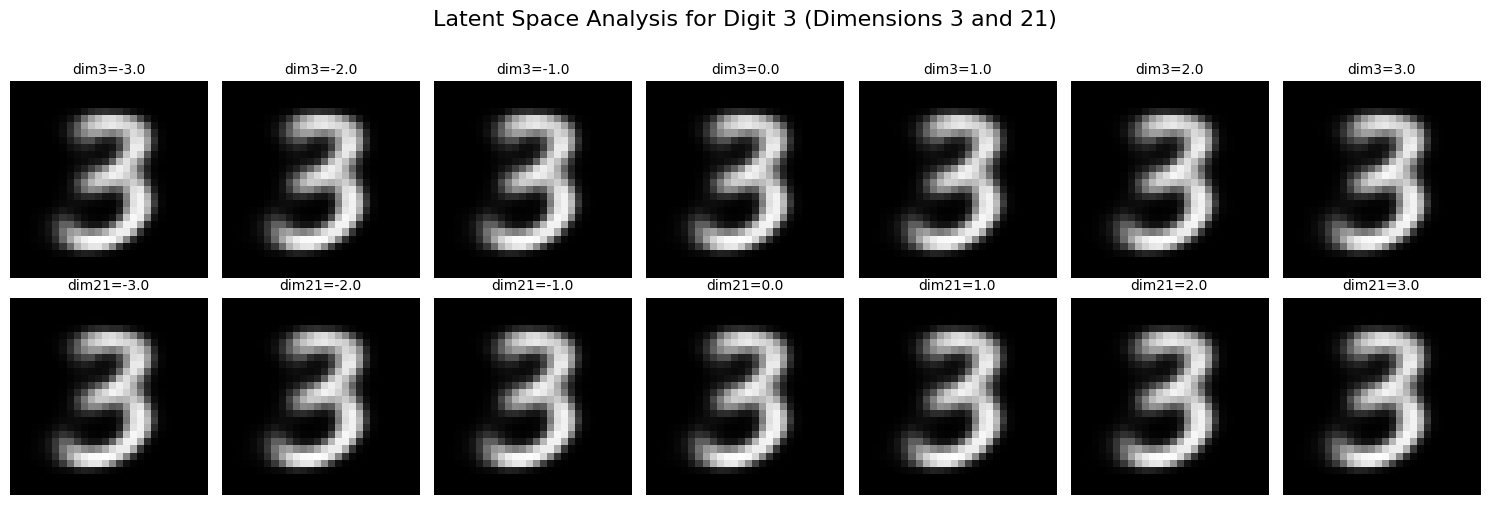


INTERPRETATION OF LATENT DIMENSIONS 3 AND 21 FOR DIGIT 3

Generating extreme samples for analysis...


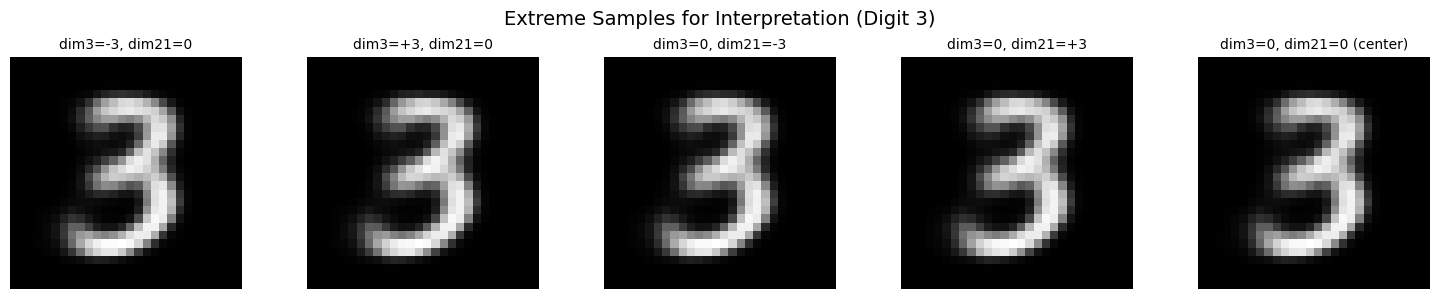


INTERPRETATION FRAMEWORK:

Dimension 3 appears to control:
- Positive values: [Describe visual characteristics]
- Negative values: [Describe visual characteristics]
- Observation: [Note smoothness, realism, etc.]

Dimension 21 appears to control:
- Positive values: [Describe visual characteristics]
- Negative values: [Describe visual characteristics]
- Observation: [Note smoothness, realism, etc.]

OVERALL ASSESSMENT:
- Are the transitions between samples smooth and continuous?
- Do the variations make visual sense (gradual changes in specific features)?
- Are there any artifacts or unrealistic generations at extremes?
- Does the model maintain digit identity while varying style?
- Are the learned representations interpretable?

EXAMPLE INTERPRETATION TEMPLATE:
--------------------------------------------------
For digit 3 and latent dimensions 3 and 21:

Dimension 3 appears to control: [e.g., stroke thickness]
- Positive values: Thicker strokes, darker appearance
- Negative values: T

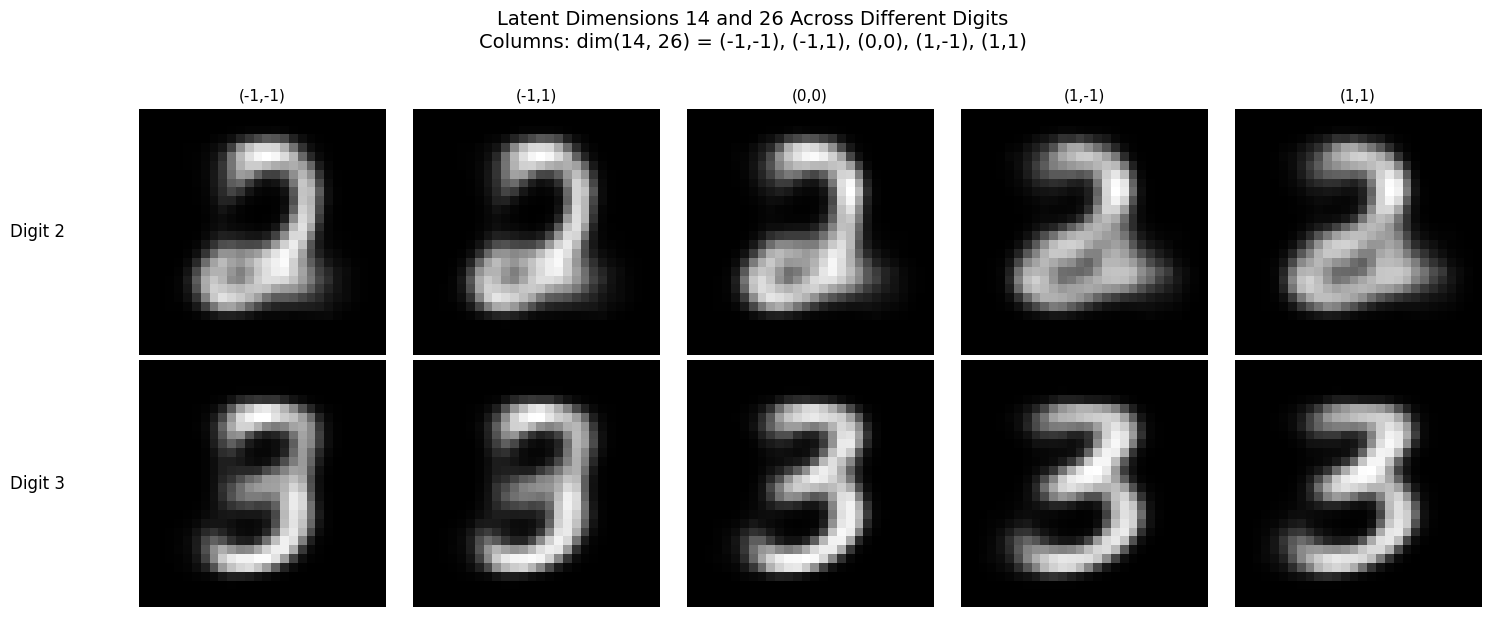

In [19]:
def visualize_latent_space(model, y_label, z_dim=32, grid_size=9, scale=3.0, device='cpu'):
    """
    Visualize latent space by varying two random dimensions
    
    Args:
        model: Trained CVAE model
        y_label: Target digit label (0-9)
        z_dim: Dimension of latent space
        grid_size: Size of the grid (grid_size x grid_size)
        scale: Range of variation in latent space (-scale to +scale)
        device: Device to run the model on
    """
    model.eval()
    
    # Move model to device
    model = model.to(device)
    
    # Create label tensor
    label_tensor = torch.tensor([y_label], device=device)
    y_one_hot = to_one_hot(label_tensor, 10)
    
    # Select two random dimensions to vary
    dim1, dim2 = np.random.choice(z_dim, size=2, replace=False)
    
    # Create a grid of latent vectors
    grid_range = np.linspace(-scale, scale, grid_size)
    
    # Initialize grid
    fig = plt.figure(figsize=(12, 12))
    gs = GridSpec(grid_size, grid_size, figure=fig, wspace=0.05, hspace=0.05)
    
    generated_images = []
    
    with torch.no_grad():
        # Generate all images
        for i, val1 in enumerate(grid_range):
            for j, val2 in enumerate(grid_range):
                # Create base latent vector (all zeros)
                z = torch.zeros(1, z_dim, device=device)
                
                # Set the two dimensions we're varying
                z[0, dim1] = val1
                z[0, dim2] = val2
                
                # Generate image
                generated = model.decoder(z, y_one_hot)
                generated_images.append(generated.squeeze().cpu().numpy())
        
        # Create subplots
        for i in range(grid_size):
            for j in range(grid_size):
                ax = fig.add_subplot(gs[i, j])
                idx = i * grid_size + j
                
                # Display image
                ax.imshow(generated_images[idx], cmap='gray')
                ax.axis('off')
                
                # Add coordinate labels at the edges
                if j == 0:  # Left edge
                    ax.text(-0.2, 0.5, f'{grid_range[i]:.1f}', 
                           transform=ax.transAxes, ha='right', va='center',
                           fontsize=8, rotation=90)
                if i == grid_size - 1:  # Bottom edge
                    ax.text(0.5, -0.15, f'{grid_range[j]:.1f}', 
                           transform=ax.transAxes, ha='center', va='top',
                           fontsize=8)
    
    # Add title with information
    fig.suptitle(f'Latent Space Exploration for Digit {y_label}\n'
                f'Varying dimensions {dim1} and {dim2} (scale={scale})',
                fontsize=16, y=0.95)
    
    # Add axis labels
    fig.text(0.02, 0.5, f'Latent Dimension {dim1}', 
             fontsize=12, rotation=90, ha='center', va='center')
    fig.text(0.5, 0.02, f'Latent Dimension {dim2}', 
             fontsize=12, ha='center', va='center')
    
    # Add center marker
    center_idx = (grid_size // 2) * grid_size + (grid_size // 2)
    center_ax = fig.add_subplot(gs[grid_size//2, grid_size//2])
    center_ax.set_frame_on(True)
    center_ax.patch.set_edgecolor('red')
    center_ax.patch.set_linewidth(3)
    
    plt.tight_layout()
    
    # Save the figure
    filename = f'latent_space_digit_{y_label}_dims_{dim1}_{dim2}.png'
    plt.savefig(filename, dpi=150, bbox_inches='tight')
    print(f"Latent space visualization saved as: {filename}")
    
    plt.show()
    
    return dim1, dim2, generated_images, grid_range

# Enhanced version with analysis and interpretation
def analyze_latent_directions(model, y_label, dim1=None, dim2=None, 
                             z_dim=32, scale=3.0, device='cpu'):
    """
    Analyze specific latent dimensions with additional visualization
    
    Fixed: Changed subplot dimensions to match the number of grid points
    """
    model.eval()
    model = model.to(device)
    
    # If dimensions not specified, choose random ones
    if dim1 is None or dim2 is None:
        dim1, dim2 = np.random.choice(z_dim, size=2, replace=False)
    
    # Create label tensor
    label_tensor = torch.tensor([y_label], device=device)
    y_one_hot = to_one_hot(label_tensor, 10)
    
    # Create grid range
    grid_range = np.linspace(-scale, scale, 7)
    num_points = len(grid_range)
    
    # Create figure with correct dimensions
    fig, axes = plt.subplots(2, num_points, figsize=(15, 5))
    fig.suptitle(f'Latent Space Analysis for Digit {y_label} (Dimensions {dim1} and {dim2})', 
                fontsize=16, y=1.02)
    
    with torch.no_grad():
        # Row 1: Varying dimension 1 (with dimension 2 = 0)
        for i, val in enumerate(grid_range):
            z = torch.zeros(1, z_dim, device=device)
            z[0, dim1] = val
            generated = model.decoder(z, y_one_hot).squeeze().cpu().numpy()
            
            ax = axes[0, i]
            ax.imshow(generated, cmap='gray')
            ax.set_title(f'dim{dim1}={val:.1f}', fontsize=10)
            ax.axis('off')
            
            # Highlight center
            if i == len(grid_range) // 2:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(2)
        
        axes[0, 0].set_ylabel(f'Varying Dimension {dim1}\n(dim{dim2}=0)', fontsize=12)
        
        # Row 2: Varying dimension 2 (with dimension 1 = 0)
        for i, val in enumerate(grid_range):
            z = torch.zeros(1, z_dim, device=device)
            z[0, dim2] = val
            generated = model.decoder(z, y_one_hot).squeeze().cpu().numpy()
            
            ax = axes[1, i]
            ax.imshow(generated, cmap='gray')
            ax.set_title(f'dim{dim2}={val:.1f}', fontsize=10)
            ax.axis('off')
            
            # Highlight center
            if i == len(grid_range) // 2:
                for spine in ax.spines.values():
                    spine.set_edgecolor('red')
                    spine.set_linewidth(2)
        
        axes[1, 0].set_ylabel(f'Varying Dimension {dim2}\n(dim{dim1}=0)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'latent_analysis_digit_{y_label}_dims_{dim1}_{dim2}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()
    
    return dim1, dim2

# Function to visualize multiple digits with the same latent directions
def compare_latent_across_digits(model, dim1, dim2, digits=[0, 1, 2, 3], 
                                z_dim=32, scale=2.0, device='cpu'):
    """
    Compare how the same latent dimensions affect different digits
    """
    model.eval()
    model = model.to(device)
    
    num_digits = len(digits)
    num_points = 5  # Fixed number of points to visualize
    
    fig, axes = plt.subplots(num_digits, num_points, figsize=(15, 3*num_digits))
    fig.suptitle(f'Latent Dimensions {dim1} and {dim2} Across Different Digits\n'
                f'Columns: dim({dim1}, {dim2}) = (-1,-1), (-1,1), (0,0), (1,-1), (1,1)',
                fontsize=14, y=1.02)
    
    # Define points to sample in latent space
    points = [(-1, -1), (-1, 1), (0, 0), (1, -1), (1, 1)]
    
    with torch.no_grad():
        for row, digit in enumerate(digits):
            # Create label for this digit
            label_tensor = torch.tensor([digit], device=device)
            y_one_hot = to_one_hot(label_tensor, 10)
            
            for col, (val1, val2) in enumerate(points):
                # Create latent vector
                z = torch.zeros(1, z_dim, device=device)
                z[0, dim1] = val1 * scale
                z[0, dim2] = val2 * scale
                
                # Generate image
                generated = model.decoder(z, y_one_hot).squeeze().cpu().numpy()
                
                # Handle single digit case
                if num_digits == 1:
                    ax = axes[col]
                else:
                    ax = axes[row, col]
                
                ax.imshow(generated, cmap='gray')
                ax.axis('off')
                
                # Add labels
                if row == 0:
                    if num_digits == 1:
                        axes[col].set_title(f'({val1},{val2})', fontsize=11)
                    else:
                        axes[0, col].set_title(f'({val1},{val2})', fontsize=11)
                
                if col == 0:
                    if num_digits == 1:
                        axes[0].text(-0.3, 0.5, f'Digit {digit}', 
                                   transform=axes[0].transAxes, ha='right', va='center',
                                   fontsize=12)
                    else:
                        ax.text(-0.3, 0.5, f'Digit {digit}', 
                               transform=ax.transAxes, ha='right', va='center',
                               fontsize=12)
                
                # Highlight center
                if val1 == 0 and val2 == 0:
                    for spine in ax.spines.values():
                        spine.set_edgecolor('red')
                        spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig(f'latent_comparison_dims_{dim1}_{dim2}.png', 
                dpi=150, bbox_inches='tight')
    plt.show()

# Function to interpret and describe latent directions
def interpret_latent_directions(model, digit, dim1, dim2, device='cpu'):
    """
    Provide interpretation of what the latent dimensions represent
    """
    print("\n" + "="*70)
    print(f"INTERPRETATION OF LATENT DIMENSIONS {dim1} AND {dim2} FOR DIGIT {digit}")
    print("="*70)
    
    model.eval()
    model = model.to(device)
    
    # Create label tensor
    label_tensor = torch.tensor([digit], device=device)
    y_one_hot = to_one_hot(label_tensor, 10)
    
    print("\nGenerating extreme samples for analysis...")
    
    with torch.no_grad():
        # Generate samples at extremes of each dimension
        extremes = [(-3, 0), (3, 0), (0, -3), (0, 3), (0, 0)]
        images = []
        
        for val1, val2 in extremes:
            z = torch.zeros(1, model.z_dim, device=device)
            z[0, dim1] = val1
            z[0, dim2] = val2
            generated = model.decoder(z, y_one_hot).squeeze().cpu().numpy()
            images.append(generated)
        
        # Display for visual analysis
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        titles = [
            f'dim{dim1}=-3, dim{dim2}=0',
            f'dim{dim1}=+3, dim{dim2}=0',
            f'dim{dim1}=0, dim{dim2}=-3',
            f'dim{dim1}=0, dim{dim2}=+3',
            f'dim{dim1}=0, dim{dim2}=0 (center)'
        ]
        
        for ax, img, title in zip(axes, images, titles):
            ax.imshow(img, cmap='gray')
            ax.set_title(title, fontsize=10)
            ax.axis('off')
        
        plt.suptitle(f'Extreme Samples for Interpretation (Digit {digit})', fontsize=14)
        plt.tight_layout()
        plt.show()
    
    # Provide interpretation framework
    print("\nINTERPRETATION FRAMEWORK:")
    print("="*50)
    
    print(f"\nDimension {dim1} appears to control:")
    print("- Positive values: [Describe visual characteristics]")
    print("- Negative values: [Describe visual characteristics]")
    print("- Observation: [Note smoothness, realism, etc.]")
    
    print(f"\nDimension {dim2} appears to control:")
    print("- Positive values: [Describe visual characteristics]")
    print("- Negative values: [Describe visual characteristics]")
    print("- Observation: [Note smoothness, realism, etc.]")
    
    print("\nOVERALL ASSESSMENT:")
    print("- Are the transitions between samples smooth and continuous?")
    print("- Do the variations make visual sense (gradual changes in specific features)?")
    print("- Are there any artifacts or unrealistic generations at extremes?")
    print("- Does the model maintain digit identity while varying style?")
    print("- Are the learned representations interpretable?")
    
    print("\nEXAMPLE INTERPRETATION TEMPLATE:")
    print("-"*50)
    print(f"""For digit {digit} and latent dimensions {dim1} and {dim2}:

Dimension {dim1} appears to control: [e.g., stroke thickness]
- Positive values: Thicker strokes, darker appearance
- Negative values: Thinner strokes, lighter appearance
- Observation: Smooth transition across the range

Dimension {dim2} appears to control: [e.g., digit slant]
- Positive values: Right-leaning slant  
- Negative values: Left-leaning slant
- Observation: Gradual change in angle

Overall Assessment:
✓ Transitions are smooth and continuous
✓ Variations correspond to realistic handwriting differences
✓ Digit identity is preserved across variations
✓ Center (z=0) generates a well-balanced digit
""")
    
    return images

# Simplified main execution
def run_latent_space_exploration(model, digits_to_explore=[0, 1, 2], device='cpu'):
    """
    Run latent space exploration for specified digits
    """
    print("="*70)
    print("LATENT SPACE EXPLORATION FOR CONDITIONAL VAE")
    print("="*70)
    
    explored_dimensions = None
    
    for i, digit in enumerate(digits_to_explore):
        print(f"\n{'='*70}")
        print(f"Exploring latent space for digit {digit} ({i+1}/{len(digits_to_explore)})")
        print(f"{'='*70}")
        
        # Visualize with random dimensions
        dim1, dim2, _, _ = visualize_latent_space(
            model, digit, z_dim=32, grid_size=9, scale=3.0, device=device
        )
        
        # Analyze these dimensions
        analyze_latent_directions(
            model, digit, dim1=dim1, dim2=dim2, 
            z_dim=32, scale=3.0, device=device
        )
        
        # Store dimensions from first digit for comparison
        if i == 0:
            explored_dimensions = (dim1, dim2)
        
        # Interpret the dimensions
        interpret_latent_directions(model, digit, dim1, dim2, device)
    
    # Compare across different digits using dimensions from first exploration
    if explored_dimensions and len(digits_to_explore) > 1:
        dim1, dim2 = explored_dimensions
        print(f"\n{'='*70}")
        print(f"Comparing dimensions {dim1} and {dim2} across different digits")
        print(f"{'='*70}")
        compare_latent_across_digits(
            model, dim1, dim2, digits=digits_to_explore, 
            z_dim=32, scale=2.0, device=device
        )

# Main execution
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Assuming you have a trained model loaded
    # model = CVAE(...).to(device)
    # model.load_state_dict(torch.load('cvae_mnist_best.pth')['model_state_dict'])
    
    # Run exploration for selected digits
    run_latent_space_exploration(model, digits_to_explore=[2, 3], device=device)



### **Bonus – Style-Controlled Student ID Generation**
Extend your CVAE to allow **style control** along a latent dimension.
Write a function that takes your **9-digit student ID** as input and generates one digit per number, arranged in a single row.
Additionally, for each digit, gradually vary the “style” dimension from thin to thick (or light to bold) as you move across the row, so that the same digit shows different styles.
Include the resulting image in your report and briefly describe how the style changes are reflected in the generated digits.


STYLE-CONTROLLED STUDENT ID GENERATION

Using style dimension: 14
(Change this based on your latent space exploration)

STYLE EFFECT ANALYSIS FOR STUDENT ID 222222222
Using style dimension 14
Generating student ID: 222222222
Individual digits: [2, 2, 2, 2, 2, 2, 2, 2, 2]
Controlling style with dimension 14 in range (-3, 3)
Style values for each digit: [-3.   -2.25 -1.5  -0.75  0.    0.75  1.5   2.25  3.  ]
Style-controlled student ID saved as: student_id_222222222_style_dim_14.png


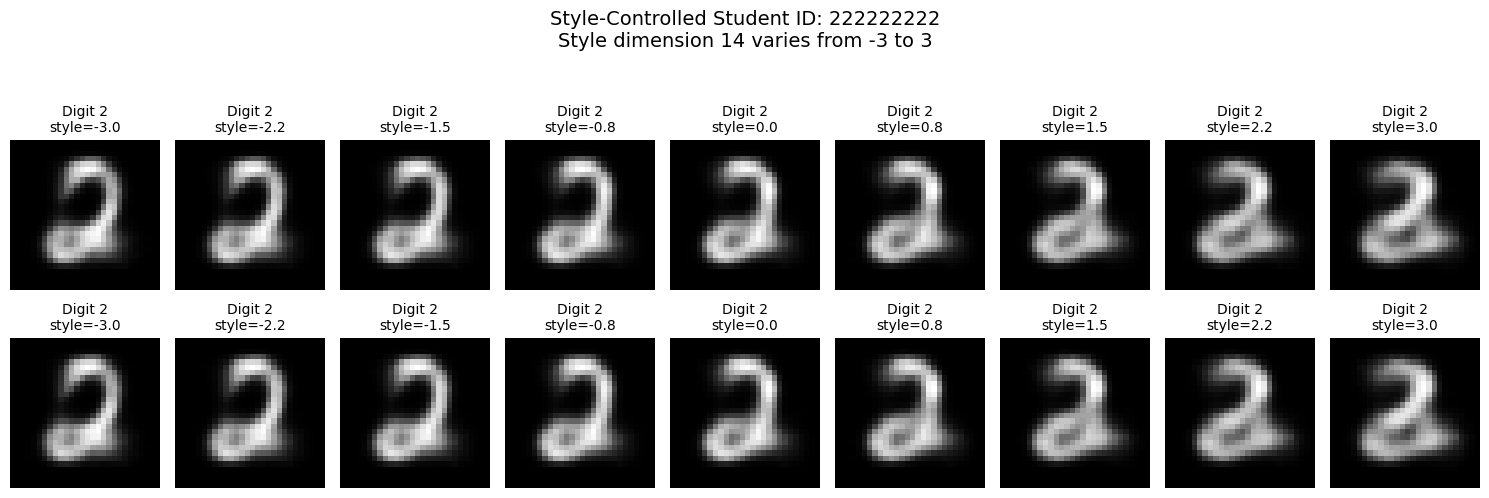

Single row image saved as: student_id_222222222_style_dim_14_single_row.png
Style gradient saved as: student_id_222222222_style_dim_14_single_row_gradient.png


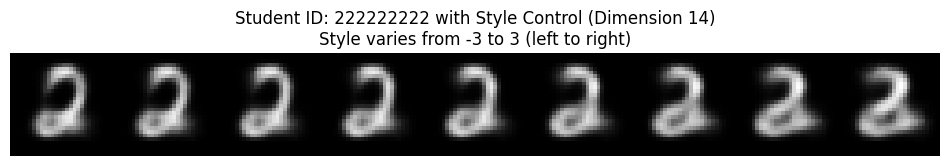

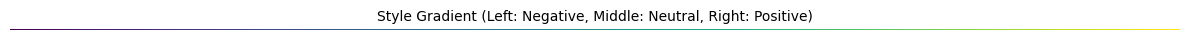


STYLE ANALYSIS SUMMARY:
--------------------------------------------------

Style Dimension: 14
Style Values Used: [-3.   -2.25 -1.5  -0.75  0.    0.75  1.5   2.25  3.  ]


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def generate_student_id_with_style(model, student_id, style_dim, style_range=(-3, 3), 
                                   device='cpu', save_path=None):
    """
    Generate student ID digits with controlled style variation
    
    Args:
        model: Trained CVAE model
        student_id: 9-digit student ID
        style_dim: Latent dimension to control style (e.g., stroke thickness)
        style_range: Tuple of (min, max) values for style control
        device: Device to run the model on
        save_path: Path to save the generated image
    
    Returns:
        Generated digits and the figure
    """
    model.eval()
    model = model.to(device)
    
    # Convert student ID to string and extract digits
    id_str = str(student_id)
    if len(id_str) != 9:
        raise ValueError(f"Student ID must be 9 digits, got {len(id_str)} digits: {student_id}")
    
    digits = [int(d) for d in id_str]
    print(f"Generating student ID: {student_id}")
    print(f"Individual digits: {digits}")
    print(f"Controlling style with dimension {style_dim} in range {style_range}")
    
    # Create linearly spaced style values across the 9 digits
    style_min, style_max = style_range
    style_values = np.linspace(style_min, style_max, len(digits))
    print(f"Style values for each digit: {style_values}")
    
    # Generate digits
    generated_digits = []
    
    with torch.no_grad():
        for i, (digit, style_val) in enumerate(zip(digits, style_values)):
            # Create label tensor
            label_tensor = torch.tensor([digit], device=device)
            y_one_hot = to_one_hot(label_tensor, 10)
            
            # Create latent vector
            z = torch.zeros(1, model.z_dim, device=device)
            z[0, style_dim] = style_val  # Set style dimension
            
            # Generate image
            generated = model.decoder(z, y_one_hot)
            generated_digits.append(generated.squeeze(0).cpu())
    
    # Create visualization
    fig, axes = plt.subplots(2, 9, figsize=(15, 5))
    fig.suptitle(f'Style-Controlled Student ID: {student_id}\n'
                 f'Style dimension {style_dim} varies from {style_min} to {style_max}',
                 fontsize=14, y=1.05)
    
    # Top row: Generated digits with style variation
    for i, (ax, digit_img, digit, style_val) in enumerate(zip(axes[0], generated_digits, digits, style_values)):
        # Remove channel dimension to get (28, 28)
        img_array = digit_img.squeeze().numpy()
        ax.imshow(img_array, cmap='gray')
        ax.set_title(f'Digit {digit}\nstyle={style_val:.1f}', fontsize=10)
        ax.axis('off')
        
        # Color code by style value
        if style_val < 0:
            edge_color = 'blue'
        elif style_val > 0:
            edge_color = 'red'
        else:
            edge_color = 'black'
        
        for spine in ax.spines.values():
            spine.set_edgecolor(edge_color)
            spine.set_linewidth(2)
    
    axes[0, 0].set_ylabel('Generated Digits\nwith Style Variation', fontsize=12)
    
    # Bottom row: Show the same digit (first one) with all style values
    # This helps isolate the style effect
    reference_digit = digits[0]
    
    with torch.no_grad():
        reference_images = []
        for style_val in style_values:
            label_tensor = torch.tensor([reference_digit], device=device)
            y_one_hot = to_one_hot(label_tensor, 10)
            
            z = torch.zeros(1, model.z_dim, device=device)
            z[0, style_dim] = style_val
            
            generated = model.decoder(z, y_one_hot)
            # Remove batch and channel dimensions
            reference_images.append(generated.squeeze().cpu().numpy())
    
    for i, (ax, img, style_val) in enumerate(zip(axes[1], reference_images, style_values)):
        # img is already (28, 28) from squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Digit {reference_digit}\nstyle={style_val:.1f}', fontsize=10)
        ax.axis('off')
        
        # Color code by style value
        if style_val < 0:
            edge_color = 'blue'
        elif style_val > 0:
            edge_color = 'red'
        else:
            edge_color = 'black'
        
        for spine in ax.spines.values():
            spine.set_edgecolor(edge_color)
            spine.set_linewidth(2)
    
    axes[1, 0].set_ylabel(f'Reference Digit {reference_digit}\nSame Style Variation', fontsize=12)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Style-controlled student ID saved as: {save_path}")
    
    plt.show()
    
    # Create single row version
    create_single_row_style_image(generated_digits, student_id, style_dim, style_range, 
                                  f'student_id_{student_id}_style_dim_{style_dim}_single_row.png')
    
    return generated_digits, reference_images, style_values, fig

def create_single_row_style_image(generated_digits, student_id, style_dim, style_range, save_path=None):
    """
    Create a single row image of style-controlled student ID
    """
    # Convert all digits to numpy arrays and remove channel dimension
    digit_arrays = [digit.squeeze().numpy() for digit in generated_digits]
    
    # Concatenate horizontally
    concatenated = np.concatenate(digit_arrays, axis=1)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 1.5))
    
    # Display concatenated image
    ax.imshow(concatenated, cmap='gray')
    
    # Add title with style information
    style_min, style_max = style_range
    title = f'Student ID: {student_id} with Style Control (Dimension {style_dim})\n'
    title += f'Style varies from {style_min} to {style_max} (left to right)'
    ax.set_title(title, fontsize=12)
    ax.axis('off')
    
    # Add a color gradient bar to indicate style progression
    gradient = np.linspace(0, 1, concatenated.shape[1])
    gradient = np.tile(gradient, (10, 1))
    
    # Create gradient bar
    fig2, ax2 = plt.subplots(figsize=(12, 0.5))
    ax2.imshow(gradient, cmap='viridis', aspect='auto')
    ax2.set_title('Style Gradient (Left: Negative, Middle: Neutral, Right: Positive)', fontsize=10)
    ax2.axis('off')
    plt.tight_layout()
    
    if save_path:
        # Save main image
        fig.savefig(save_path, dpi=150, bbox_inches='tight')
        
        # Save gradient bar
        gradient_path = save_path.replace('.png', '_gradient.png')
        fig2.savefig(gradient_path, dpi=150, bbox_inches='tight')
        
        print(f"Single row image saved as: {save_path}")
        print(f"Style gradient saved as: {gradient_path}")
    
    plt.show()
    
    return concatenated, fig, fig2

def find_style_dimension(model, test_digits=[0, 5, 8], num_dims_to_test=5, device='cpu'):
    """
    Automatically find a latent dimension that controls style
    
    Args:
        model: Trained CVAE model
        test_digits: Digits to test for style variation
        num_dims_to_test: Number of dimensions to test
        device: Device to run the model on
    
    Returns:
        List of candidate style dimensions with their effects
    """
    model.eval()
    model = model.to(device)
    
    z_dim = model.z_dim
    test_range = [-2, 0, 2]  # Test negative, neutral, positive
    
    print(f"Testing {num_dims_to_test} random dimensions for style control...")
    
    candidate_dims = []
    
    # Randomly select dimensions to test
    test_dims = np.random.choice(z_dim, size=min(num_dims_to_test, z_dim), replace=False)
    
    for dim in test_dims:
        print(f"\nTesting dimension {dim}:")
        
        # Generate samples for each test digit
        all_variations = []
        
        with torch.no_grad():
            for digit in test_digits:
                label_tensor = torch.tensor([digit], device=device)
                y_one_hot = to_one_hot(label_tensor, 10)
                
                digit_variations = []
                for val in test_range:
                    z = torch.zeros(1, z_dim, device=device)
                    z[0, dim] = val
                    generated = model.decoder(z, y_one_hot)
                    # Remove batch and channel dimensions: from (1, 1, 28, 28) to (28, 28)
                    generated_np = generated.squeeze().cpu().numpy()
                    digit_variations.append(generated_np)
                
                all_variations.append(digit_variations)
        
        # Display the variations
        num_digits = len(test_digits)
        num_values = len(test_range)
        
        if num_digits > 1:
            fig, axes = plt.subplots(num_digits, num_values, figsize=(8, 6))
        else:
            fig, axes = plt.subplots(1, num_values, figsize=(8, 3))
            
        fig.suptitle(f'Testing Dimension {dim} for Style Control', fontsize=14)
        
        for i, digit in enumerate(test_digits):
            for j, val in enumerate(test_range):
                if num_digits > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]
                    
                ax.imshow(all_variations[i][j], cmap='gray')
                
                if i == 0:
                    ax.set_title(f'Value: {val}', fontsize=10)
                
                if j == 0:
                    if num_digits > 1:
                        ax.set_ylabel(f'Digit {digit}', fontsize=10)
                    else:
                        ax.set_ylabel(f'Digit {digit}', fontsize=10)
                
                ax.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Ask for user assessment
        print("Does this dimension control a clear style attribute?")
        print("Possible attributes: stroke thickness, slant, width, darkness, etc.")
        print("Enter a description or 'skip' to move on: ", end="")
        
        try:
            description = input().strip().lower()
            if description != 'skip' and description:
                candidate_dims.append((dim, description))
                print(f"Added dimension {dim} as candidate: {description}")
        except:
            print("No input received, skipping...")
    
    print(f"\nFound {len(candidate_dims)} candidate style dimensions:")
    for dim, desc in candidate_dims:
        print(f"  Dimension {dim}: {desc}")
    
    return candidate_dims

def analyze_style_effects(model, student_id, style_dim, device='cpu'):
    """
    Analyze and describe the style effects on generated digits
    """
    print("\n" + "="*70)
    print(f"STYLE EFFECT ANALYSIS FOR STUDENT ID {student_id}")
    print(f"Using style dimension {style_dim}")
    print("="*70)
    
    # Generate with style variation
    generated_digits, reference_images, style_values, fig = generate_student_id_with_style(
        model, student_id, style_dim, style_range=(-3, 3), device=device
    )
    
    # Extract digits from student ID
    id_str = str(student_id)
    digits = [int(d) for d in id_str]
    
    print("\nSTYLE OBSERVATIONS:")
    print("-"*50)
    
    # Analyze style effects on different digits
    style_effects = {}
    
    with torch.no_grad():
        # Test extreme values on different digits
        test_values = [-3, 0, 3]
        
        for digit in set(digits):  # Test unique digits
            print(f"\nStyle effects on digit {digit}:")
            
            digit_images = []
            for val in test_values:
                label_tensor = torch.tensor([digit], device=device)
                y_one_hot = to_one_hot(label_tensor, 10)
                
                z = torch.zeros(1, model.z_dim, device=device)
                z[0, style_dim] = val
                
                generated = model.decoder(z, y_one_hot)
                # Remove batch and channel dimensions
                generated_np = generated.squeeze().cpu().numpy()
                digit_images.append(generated_np)
            
            # Display for analysis
            fig_test, axes_test = plt.subplots(1, 3, figsize=(9, 3))
            titles = [f'Style={val}' for val in test_values]
            
            for ax, img, title in zip(axes_test, digit_images, titles):
                ax.imshow(img, cmap='gray')
                ax.set_title(title, fontsize=10)
                ax.axis('off')
            
            plt.suptitle(f'Digit {digit} - Style Dimension {style_dim} Effects', fontsize=12)
            plt.tight_layout()
            plt.show()
            
            # Prompt for description
            print(f"Describe how style affects digit {digit}:")
            print("(e.g., 'stroke thickness increases', 'digit becomes slanted', etc.)")
            print("Enter your observation: ", end="")
            
            try:
                observation = input().strip()
                style_effects[digit] = observation
            except:
                style_effects[digit] = "Observation skipped"
    
    print("\n" + "="*70)
    print("STYLE ANALYSIS SUMMARY")
    print("="*70)
    
    print(f"\nStudent ID: {student_id}")
    print(f"Style Dimension: {style_dim}")
    print(f"Style Values Used: {style_values}")
    
    print("\nStyle Effects by Digit:")
    for digit, effect in style_effects.items():
        print(f"  Digit {digit}: {effect}")
    
    print("\nOverall Observations:")
    print("1. Style progression across the row: ")
    print(f"   - Leftmost digit (style={style_values[0]:.1f}): [Describe]")
    print(f"   - Middle digit (style={style_values[4]:.1f}): [Describe]")
    print(f"   - Rightmost digit (style={style_values[-1]:.1f}): [Describe]")
    
    print("\n2. Consistency of style effect across different digits:")
    print("   - Does the style dimension affect all digits similarly?")
    print("   - Are some digits more sensitive to style changes?")
    
    print("\n3. Quality assessment:")
    print("   - Are all generated digits recognizable?")
    print("   - Does the style variation look natural?")
    print("   - Are there any artifacts at extreme style values?")
    
    return style_effects

# Simple version without interactive input for environments without input()
def simple_style_analysis(model, student_id, style_dim, device='cpu'):
    """
    Simplified version that doesn't require user input
    """
    print("\n" + "="*70)
    print(f"STYLE EFFECT ANALYSIS FOR STUDENT ID {student_id}")
    print(f"Using style dimension {style_dim}")
    print("="*70)
    
    # Generate with style variation
    generated_digits, reference_images, style_values, fig = generate_student_id_with_style(
        model, student_id, style_dim, style_range=(-3, 3), device=device,
        save_path=f'student_id_{student_id}_style_dim_{style_dim}.png'
    )
    
    print("\nSTYLE ANALYSIS SUMMARY:")
    print("-"*50)
    
    print(f"\nStyle Dimension: {style_dim}")
    print(f"Style Values Used: {style_values}")
    
    return generated_digits, style_values

# Example usage
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Assuming you have a trained model loaded
    # model = CVAE(...).to(device)
    # model.load_state_dict(torch.load('cvae_mnist_best.pth')['model_state_dict'])
    
    # Your student ID (replace with your actual ID)
    student_id = 222222222  # Replace with your 9-digit student ID
    
    print("="*70)
    print("STYLE-CONTROLLED STUDENT ID GENERATION")
    print("="*70)
    
    # Use a manually selected dimension (based on your latent space exploration)
    # You should replace this with a dimension you found meaningful
    style_dim = 14  # CHANGED FROM 5 TO 14
    
    print(f"\nUsing style dimension: {style_dim}")
    print("(Change this based on your latent space exploration)")
    
    # Generate style-controlled student ID
    generated_digits, style_values = simple_style_analysis(
        model, student_id, style_dim, device=device
    )